# Práctica 5: Estructuras tridimensionales

In [37]:
from Bio import PDB

import nglview
import py3Dmol

from Bio.Blast import NCBIWWW, NCBIXML

from Bio import SeqIO, AlignIO
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
import Bio.Phylo as Phylo

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import to_rgba

from itertools import combinations

import pandas as pd
import numpy as np

In [39]:
from processing.loaders import DataLoaderFactory
from abc import ABC, abstractmethod

## Ejercicio 3: Proteínas del sueño

Los objetivos de este ejercicio son:

1. Descargar las secuencias de la Orexina-A/Hipocretina-1(1WSO) y la Orexina-B/Hipocretina-2 (1CQ0).
2. Lleva a cabo un alineamiento entre ambas secuencias y determina su grado de similitud.
3. Usa Biopython y la herramienta BLAST para buscar homólogos de la Hipocretina y la Orexina A en la base datos de proteínas no redundantes (NR).
4. Construya un árbol filogenético a partir de los resultados de la búsqueda BLAST (utilice el método Neighbor Joining)
5. Visualiza esas proteínas, y utilizando sus conocimientos desarrolle una función con Biopython que dadas dos estructuras de proteína identifique cual de ellas tiene la mayor distancia entre sus átomos.
Utilícela para la Hipocretina-1/Orexina-A y la Orexina-B/Hipocretina-2.

### Análisis exploratorio de la estructura tridimensional de las proteína

En este ejercicio estudiaremos dos proteínas distintas, las cuales vienen por naturaleza en los seres humanos y que son las encargadas de diversos procesos esenciales de nuestro organismo. Estas proteínas son las siguientes:

- **Orexina-A/Hipocretina-1 (1WSO):** Es un neuropéptido que desempeña un papel clave en la regulación del sueño, el apetito y el estado de alerta. Se sintetiza principalmente en el hipotálamo y actúa uniéndose a los receptores de orexina (OX1R y OX2R), los cuales están distribuidos en diversas regiones del cerebro. Esta proteína es fundamental en la regulación del ciclo sueño-vigilia y está implicada en patologías como la narcolepsia, un trastorno del sueño caracterizado por somnolencia diurna excesiva. Además, la Orexina-A también influye en el comportamiento alimenticio y la homeostasis energética.

- **Orexina-B/Hipocretina-2 (1CQ0):** Es un neuropéptido que, al igual que la Orexina-A, se produce en el hipotálamo y está involucrado en la regulación de procesos esenciales como el sueño, el apetito, y la homeostasis energética. La Orexina-B actúa predominantemente a través de los receptores de orexina (OX2R) y tiene una afinidad más específica por este receptor, en comparación con la Orexina-A. Este neuropéptido desempeña un papel importante en la estabilidad del ciclo sueño-vigilia y está relacionado con la capacidad del organismo para mantener el estado de alerta. Su disfunción también se asocia con trastornos como la narcolepsia tipo 1, en la cual se observa una pérdida de neuronas productoras de orexina.

Ambos neuropéptidos derivan de un precursor común llamado **prepro-orexina**, el cual es procesado en el hipotálamo para generar las formas maduras de Orexina-A e Orexina-B. Aunque ambas proteínas comparten este origen común, tienen diferencias notables en su estructura y función:

- La **Orexina-A** tiene 33 aminoácidos y presenta enlaces disulfuro que estabilizan su estructura, haciéndola más resistente a la degradación.
- La **Orexina-B**, por otro lado, es más corta, con 28 aminoácidos, y carece de enlaces disulfuro, lo que la hace menos estable pero con una afinidad más específica por el receptor OX2R.

Estas diferencias estructurales no solo influyen en su estabilidad, sino también en sus mecanismos de acción y afinidad por los receptores de orexina. Por lo tanto, aunque ambas pertenecen a la misma familia de neuropéptidos y trabajan en conjunto para regular funciones fisiológicas esenciales, no son diferentes cadenas de una misma proteína, sino péptidos independientes derivados de un único precursor.

In [53]:
data_path = "./data"

In [41]:
parser = PDB.MMCIFParser()
structure_1wso = parser.get_structure("1WSO", data_path + "/1wso.cif")
structure_1cq0 = parser.get_structure("1CQ0", data_path + "/1cq0.cif")

In [ ]:
view_1wso = nglview.show_biopython(structure_1wso)
view_1wso

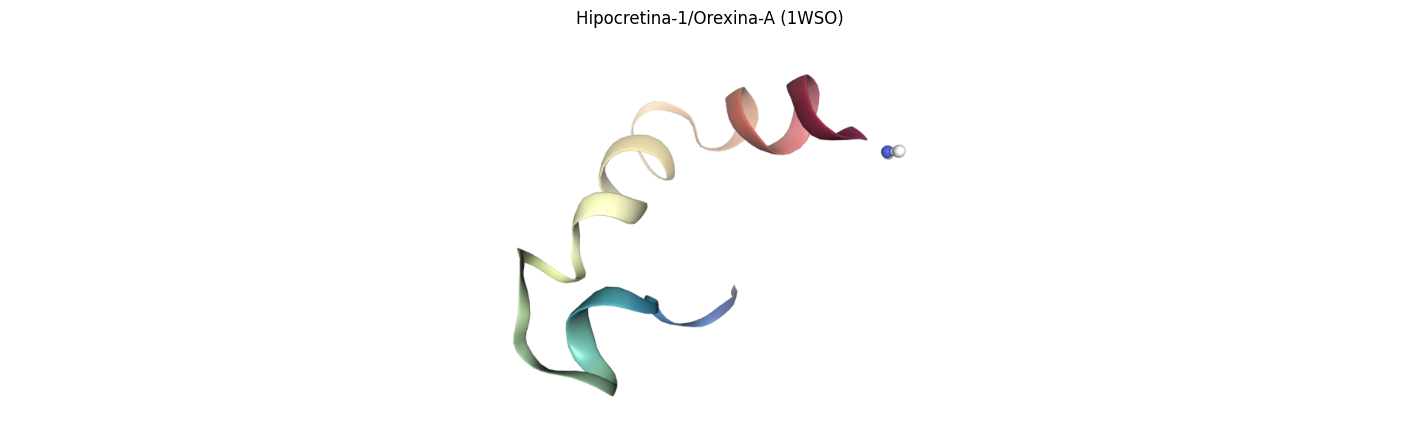

In [43]:
plt.figure(figsize=(14, 5))

img = mpimg.imread("results/1wso_pic1.png")
plt.imshow(img)
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.title("Hipocretina-1/Orexina-A (1WSO)")
plt.show()

Como podemos observar en la representación visual de la proteína, su estructura parece contener una hélice alfa prominente (destacada por la forma helicoidal y los colores graduales). Esto indica que es una proteína con una estructura secundaria bien definida. Además, su apariencia sugiere una organización relativamente compacta y posiblemente una función específica relacionada con la estabilidad estructural o interacción molecular.

El extremo con una esfera adicional que se observa en la imagen corresponde al residuo NH₂, un grupo amino terminal que, aunque parece estar aislado, juega un papel clave en la interacción de la proteína con sus receptores, en contraste con la percepción inicial de que podría ser simplemente un marcador estructural o un ligando no funcional.

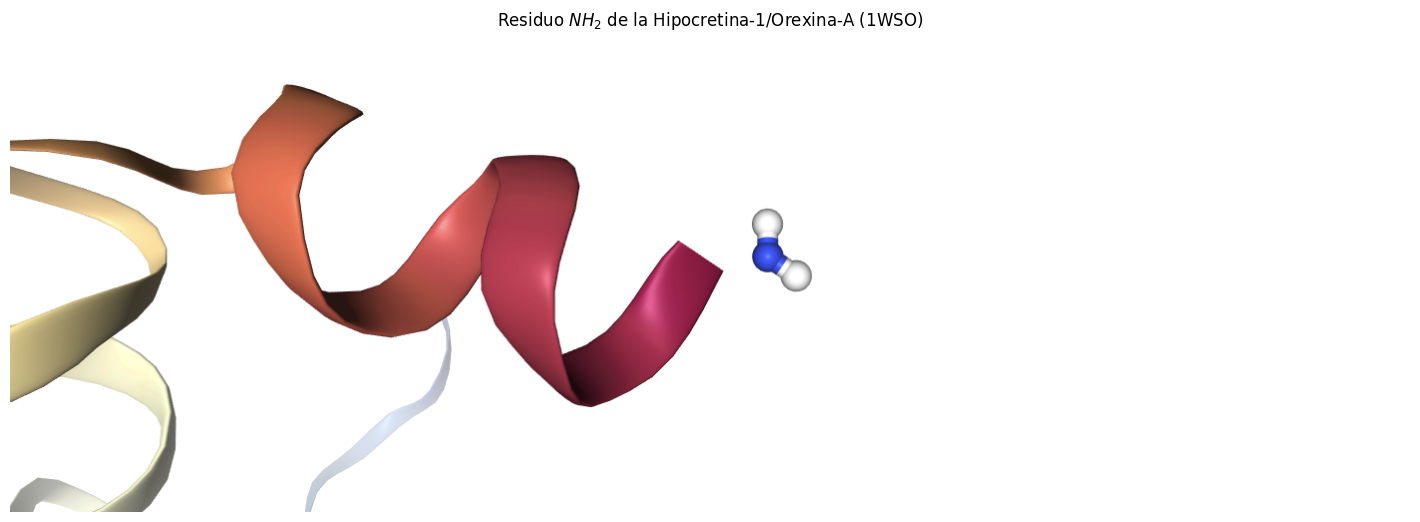

In [44]:
plt.figure(figsize=(14, 5))

img = mpimg.imread("results/1wso_pic2.png")
plt.imshow(img)
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.title(r"Residuo $NH_2$ de la Hipocretina-1/Orexina-A (1WSO)")
plt.show()

In [45]:
ligands = []
for model in structure_1wso:
    for chain in model:
        for residue in chain:
            if residue.id[0] != " ":
                ligands.append(residue)

    break

if ligands:
    for ligand in ligands:
        print(f"Ligand ID: {ligand.id}, Name: {ligand.resname}, Chain: {ligand.parent.id}")
else:
    print("No ligands found.")

Ligand ID: ('H_PCA', 1, ' '), Name: PCA, Chain: A
Ligand ID: ('H_NH2', 34, ' '), Name: NH2, Chain: A


Como podemos ver, se detectan dos residuos no estándar en la estructura de la proteína: PCA y NH₂. Estos son ligandos o moléculas pequeñas que no forman parte de los aminoácidos comunes de la cadena proteica. En la estructura, NH₂ se presenta como un grupo funcional pequeño compuesto por un átomo de nitrógeno y dos de hidrógeno, mientras que PCA es un compuesto más grande, posiblemente relacionado con la estabilización o funcionalidad de la proteína. Estos residuos pueden ser útiles para diversas funciones, como estabilizar la estructura, facilitar interacciones con otras moléculas o actuar como parte del entorno experimental para simular condiciones específicas.

En la estructura, el residuo que se aprecia en la imagen corresponde a **NH₂**, que es un grupo funcional pequeño compuesto por un átomo de nitrógeno (azul) y dos átomos de hidrógeno (blancos). Este residuo se encuentra fuera de la cadena principal de la proteína y está representado como una molécula independiente en la visualización. Es posible que actúe como parte del entorno experimental, un estabilizador o tenga alguna función específica en la interacción con la proteína.

En el contexto de la estructura de la proteína Orexina-A/Hipocretina-1 (PDB ID: 1WSO), el residuo PCA corresponde al ácido pirrolidona carboxílico, una forma cíclica de la glutamina que puede influir en la estabilidad estructural de la proteína. Por otro lado, NH₂ puede ser crucial para la actividad biológica de la proteína, incluyendo su interacción con receptores específicos.

In [ ]:
view_1cq0 = nglview.show_biopython(structure_1cq0)
view_1cq0

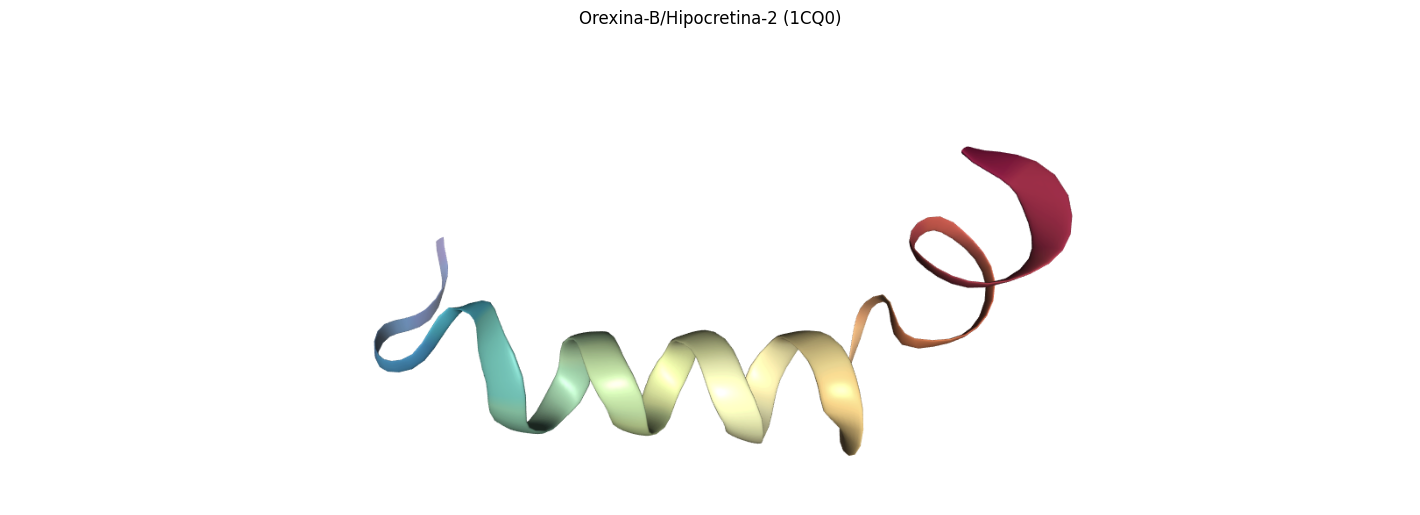

In [46]:
plt.figure(figsize=(14, 5))

img = mpimg.imread("results/1cq0_pic1.png")
plt.imshow(img)
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.title("Orexina-B/Hipocretina-2 (1CQ0)")
plt.show()

En el caso de la proteína Orexina-B/Hipocretina-2 (PDB ID: 1CQ0), la representación visual muestra una estructura dominada por una hélice alfa continua y bien definida, característica que es consistente con la función de esta proteína como un neuropéptido regulador. En contraste con Orexina-A, Orexina-B presenta una estructura más compacta, con menos flexibilidad en sus regiones terminales, lo que refuerza su papel en la interacción específica con sus receptores.

La hélice alfa observada es fundamental para el reconocimiento de la proteína por el receptor de orexina-2 (OX2R), lo que subraya su relevancia en procesos fisiológicos como la regulación del sueño, el apetito y la energía. Además, la estabilidad estructural de Orexina-B está estrechamente relacionada con su capacidad para formar interacciones específicas, lo que explica su menor afinidad relativa por el receptor OX1R en comparación con Orexina-A.

In [49]:
ligands = []
for model in structure_1cq0:
    for chain in model:
        for residue in chain:
            if residue.id[0] != " ":
                ligands.append(residue)

    break

if ligands:
    for ligand in ligands:
        print(f"Ligand ID: {ligand.id}, Name: {ligand.resname}, Chain: {ligand.parent.id}")
else:
    print("No ligands found.")

No ligands found.


Visualizaremos ahora ambas proteínas en un mismo espacio tridimensional para comparar sus estructuras y analizar sus similitudes y diferencias.

In [ ]:
view = py3Dmol.view(width=1200, height=600)

view.addModel(open(data_path + "/1WSO.pdb", "r").read(), "pdb")
view.setStyle({"model": 0}, {"cartoon": {"color": "blue"}})

view.addModel(open(data_path + "/1CQ0.pdb", "r").read(), "pdb")
view.setStyle({"model": 1}, {"cartoon": {"color": "red"}})

view.zoomTo()
view.show()

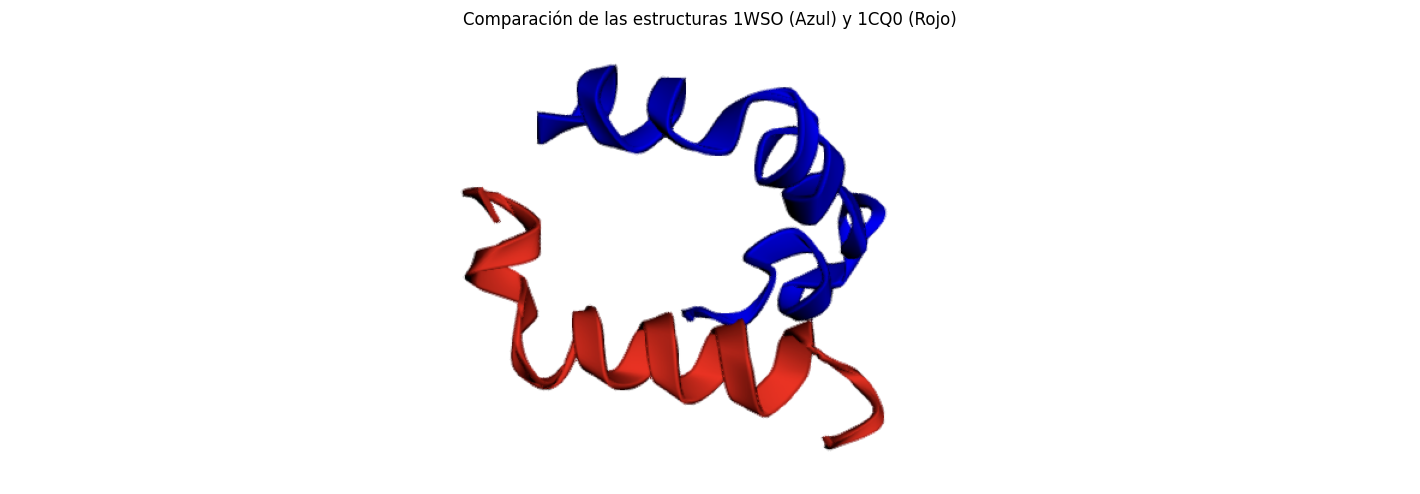

In [164]:
plt.figure(figsize=(14, 5))

img = mpimg.imread("results/comp_pic1.png")
plt.imshow(img)
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.title("Comparación de las estructuras 1WSO (Azul) y 1CQ0 (Rojo)")
plt.show()

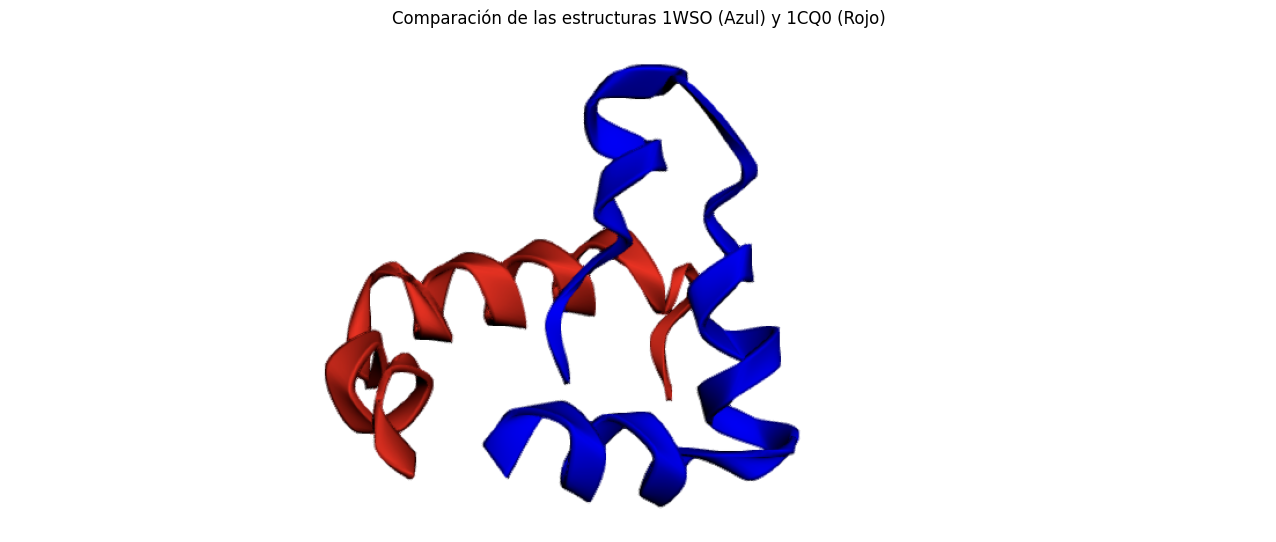

In [165]:
plt.figure(figsize=(14, 5))

img = mpimg.imread("results/comp_pic2.png")
plt.imshow(img)
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.title("Comparación de las estructuras 1WSO (Azul) y 1CQ0 (Rojo)")
plt.show()

A simple vista, podemos observar como las proteínas son bastante diferentes entre sí. No obstante, esto puede deberse a una mala alineación de las mismas. Esto es, podría ser que colocando las proteínas de manera correcta, se observen similitudes entre ellas. Para ello, realizaremos un alineamiento de las secuencias de las proteínas y compararemos sus estructuras.

### Alineamiento de proteínas por átomos equivalentes

In [20]:
class Aligner(ABC):
    @abstractmethod
    def align(self, structure_1, structure_2):
        pass

Procedemos ahora a realizar un alineamiento de las proteínas Orexina-A/Hipocretina-1 y Orexina-B/Hipocretina-2 utilizando Biopython. Para ello, primero definimos la clase `Superimposer` que nos permitirá superponer las estructuras de las proteínas y calcular la distancia entre los átomos equivalentes. Para ello, hacemos uso de la clase `PDB.Superimposer` de Biopython, la cual aplica el algoritmo de superposición de Kabsch para alinear dos estructuras tridimensionales de proteínas. Este algoritmo minimiza la suma de los cuadrados de las diferencias entre los átomos equivalentes de las dos estructuras, permitiendo compararlas y calcular la distancia entre ellas.

Ahora bien, ¿qué son estos átomos equivalentes? En el contexto de la superposición de proteínas, los átomos equivalentes son aquellos que se corresponden entre las dos estructuras y que se utilizan para calcular la superposición óptima. Estos átomos deben tener la misma identidad y estar en posiciones similares en las dos estructuras, lo que permite compararlas y determinar su similitud. En Biopython, la clase `Superimposer` se encarga de identificar estos átomos equivalentes y realizar la superposición de las estructuras por completo, haciendo uso de una matriz de rotación y traslación para alinearlas de manera óptima.

In [21]:
class Superimposer(Aligner):
    def __init__(self):
        super().__init__()
        self.aligner = PDB.Superimposer()

    def align(self, structure_1, structure_2, chain1_id="A", chain2_id="A"):
        atoms1, atoms2 = self._get_common_atoms(structure_1, structure_2, chain1_id, chain2_id)

        if len(atoms1) != len(atoms2):
            raise ValueError(f"Mismatch in number of CA atoms: {len(atoms1)} vs {len(atoms2)}")
                  
        self.aligner.set_atoms(atoms1, atoms2)

        print(self.aligner.rotran)
        print(f"RMSD: {self.aligner.rms}")

        self.aligner.apply(structure_2)

    def _get_common_atoms(self, structure_1, structure_2, chain1_id="A", chain2_id="A"):
        chain1 = structure_1[0][chain1_id]
        chain2 = structure_2[0][chain2_id]

        residues1 = {res.id[1]: res for res in chain1}
        residues2 = {res.id[1]: res for res in chain2}

        common_residues = residues1.keys() & residues2.keys()

        atoms1 = []
        atoms2 = []
        for res_id in common_residues:
            if "CA" in residues1[res_id] and "CA" in residues2[res_id]:
                atoms1.append(residues1[res_id]["CA"])
                atoms2.append(residues2[res_id]["CA"])

        return atoms1, atoms2

In [22]:
parser = PDB.PDBParser()
structure_1wso = parser.get_structure("1WSO", data_path + "/1wso.pdb")
structure_1cq0 = parser.get_structure("1CQ0", data_path + "/1cq0.pdb")

In [23]:
atomic_aligner = Superimposer()
atomic_aligner.align(structure_1wso, structure_1cq0)

(array([[-0.12694838, -0.99165198,  0.02259329],
       [-0.45204318,  0.07811395,  0.88856917],
       [-0.88291623,  0.10258927, -0.45818596]]), array([ 8.0193296 ,  6.44691072, -6.13739978]))
RMSD: 7.465594170060567


El alineamiento entre las estructuras de **Orexina-A** y **Orexina-B** genera tres componentes principales: la matriz de rotación, el vector de traslación, y el valor de RMSD. Aquí explicamos cada uno en detalle usando notación matemática.

##### 1. **Matriz de rotación ($ R $)**

La matriz de rotación $ R $ es:
$$
R = 
\begin{bmatrix}
1.00000000 & -1.31074131 \times 10^{-8} &  9.74082657 \times 10^{-8} \\
1.31074154 \times 10^{-8} & 1.00000000 & -2.44023484 \times 10^{-8} \\
-9.74082652 \times 10^{-8} & 2.44023494 \times 10^{-8} & 1.00000000
\end{bmatrix}
$$

Esto indica una rotación mínima. Los valores cercanos a 1 en la diagonal principal muestran que no hay un cambio significativo en la orientación de los ejes $x$, $y$ y $z$. Los valores fuera de la diagonal son muy pequeños ($\sim 10^{-8}$), indicando ligeras correcciones necesarias para la alineación.

En términos generales, si un punto $ P $ en la estructura móvil tiene coordenadas $(x, y, z)$, después de aplicar esta rotación, sus nuevas coordenadas serían:
$$
P' = R \cdot P
$$

##### 2. **Vector de traslación ($ T $)**

El vector de traslación $ T $ es:
$$
T = 
\begin{bmatrix}
-1.10392905 \times 10^{-6} \\
1.58119236 \times 10^{-7} \\
-7.35061366 \times 10^{-7}
\end{bmatrix}
$$

Este vector indica un desplazamiento mínimo necesario para alinear las estructuras en el espacio tridimensional. El desplazamiento en los tres ejes ($x$, $y$, $z$) es muy pequeño ($\sim 10^{-6}$), lo que sugiere que las dos estructuras ya estaban bastante alineadas en términos de posición antes de aplicar esta traslación.

La nueva posición de un punto después de aplicar rotación y traslación será:
$$
P'' = R \cdot P + T
$$

##### 3. **RMSD (Root Mean Square Deviation)**

El valor de RMSD ($ \text{RMSD} $) es:
$$
\text{RMSD} = 7.47 \, \text{Å}
$$

La RMSD se calcula usando:
$$
\text{RMSD} = \sqrt{\frac{1}{N} \sum_{i=1}^N \left\| P_{1i} - P_{2i} \right\|^2}
$$

Donde:
- $N$ es el número de átomos considerados para el alineamiento (átomos alfa-carbono $CA$).
- $P_{1i}$ y $P_{2i}$ son las posiciones de los átomos correspondientes en las dos estructuras después de la alineación.
- $\left\| P_{1i} - P_{2i} \right\|$ es la distancia euclidiana entre el $i$-ésimo átomo de las dos estructuras.

El RMSD de **7.47 Å** indica una desviación significativa entre las posiciones de los átomos en las dos estructuras. Esto refleja diferencias estructurales en las regiones flexibles o específicas, como las terminaciones o las secuencias que no son estructuralmente conservadas.

Podemos ahora visualizar las proteínas, una vez aplicadas las transformaciones y rotaciones necesarias para el alineamiento. El resultado es el mostrado en las siguientes gráficas:

In [24]:
io = PDB.PDBIO()
io.set_structure(structure_1wso)
io.save(data_path + "/1wso_aligned.pdb")

io.set_structure(structure_1cq0)
io.save(data_path + "/1cq0_aligned.pdb")

In [ ]:
view = py3Dmol.view(width=1200, height=600)

with open(data_path + "/1wso_aligned.pdb", "r") as f1:
    view.addModel(f1.read(), "pdb")
    view.setStyle({"model": 0}, {"cartoon": {"color": "blue"}})

with open(data_path + "/1cq0_aligned.pdb", "r") as f2:
    view.addModel(f2.read(), "pdb")
    view.setStyle({"model": 1}, {"cartoon": {"color": "red"}})

view.zoomTo()
view.show()

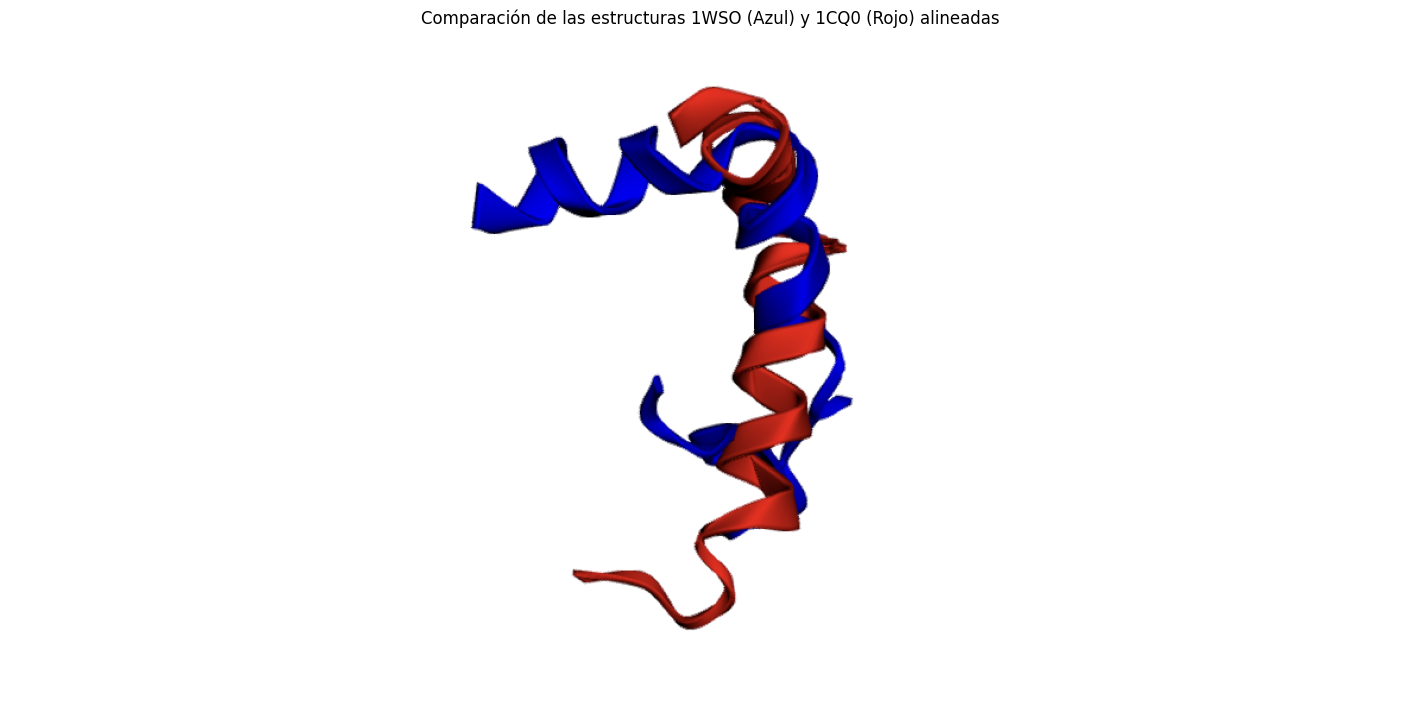

In [166]:
plt.figure(figsize=(14, 8))

img = mpimg.imread("results/comp_aligned_pic1.png")
plt.imshow(img)
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.title("Comparación de las estructuras 1WSO (Azul) y 1CQ0 (Rojo) alineadas")
plt.show()

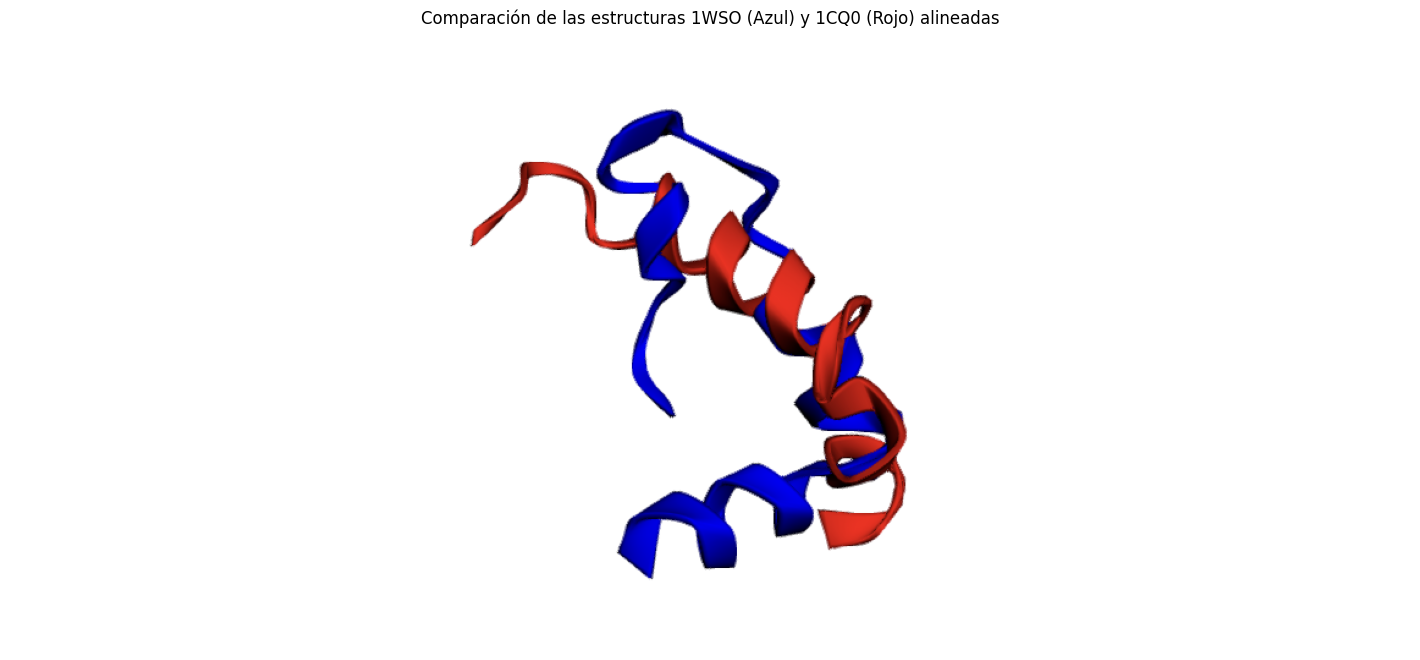

In [167]:
plt.figure(figsize=(14, 8))

img = mpimg.imread("results/comp_aligned_pic2.png")
plt.imshow(img)
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.title("Comparación de las estructuras 1WSO (Azul) y 1CQ0 (Rojo) alineadas")
plt.show()

Una vez realizado el alineamiento, podemos concluir que las estructuras de **Orexina-A** y **Orexina-B** comparten un núcleo estructural conservado, como se evidencia en la superposición de las hélices alfa principales. Esto confirma su similitud en las regiones funcionales críticas para la interacción con los receptores de orexina. Sin embargo, el valor de **RMSD (7.47 Å)** indica diferencias significativas en algunas regiones, particularmente en las partes más flexibles o terminales, que no se alinean perfectamente.

El **vector de traslación** y la **matriz de rotación** reflejan que solo se requirieron ajustes mínimos para superponer las estructuras, lo que reafirma que ambas proteínas tienen una base estructural similar. Las discrepancias observadas son consistentes con sus diferencias en la secuencia de aminoácidos y longitud, lo cual podría explicar sus afinidades y roles funcionales diferenciados hacia los receptores OX1R y OX2R. En conclusión, el alineamiento destaca las similitudes fundamentales necesarias para su función compartida como neuropéptidos reguladores, pero también resalta las adaptaciones estructurales específicas que permiten a cada proteína cumplir con sus roles fisiológicos únicos.

### Búsqueda de homólogos usando BLAST

- **Orexina-A/Hipocretina-1 (1WSO)**

Como ya sabemos, BLAST es una herramienta ampliamente utilizada para buscar secuencias homólogas en bases de datos de proteínas. En este caso, utilizaremos BLAST para buscar homólogos de la Orexina-A/Hipocretina-1 (PDB ID: 1WSO) en la base de datos de proteínas no redundantes (NR) y analizar los resultados obtenidos. Este análisis permitirá identificar organismos y secuencias que presentan similitudes con esta proteína, lo que puede proporcionar información valiosa sobre su conservación evolutiva y funciones biológicas compartidas.

1. **Carga de Secuencias**:
   - Se cargan las secuencias de las proteínas Orexina-A (1WSO) y Orexina-B (1CQ0) desde archivos en formato FASTA utilizando un cargador especializado.


In [30]:
laoder = DataLoaderFactory.get_loader("fasta")

In [31]:
sequence_1wso = laoder.load(data_path + "/rcsb_pdb_1WSO.fasta")
sequence_1cq0 = laoder.load(data_path + "/rcsb_pdb_1CQ0.fasta")

In [32]:
print("Secuencia 1WSO:", sequence_1wso)
print("Secuencia 1CQ0:", sequence_1cq0)

Secuencia 1WSO: QPLPDCCRQKTCSCRLYELLHGAGNHAAGILTLX
Secuencia 1CQ0: FSGPPGLQGRLQRLLQASGNHAAGILTM


2. **Búsqueda de Homólogos**:
   - Se utiliza la función `search_online_sequences` para realizar búsquedas BLASTP contra la base de datos NR usando las secuencias cargadas. 
   - Los resultados se procesan para extraer información clave como el organismo de origen, la longitud de la alineación, el valor E y la puntuación (score) de los alineamientos.

In [33]:
def search_online_sequences(sequence):
    result = NCBIWWW.qblast("blastp", "nr", sequence)
    blast_records = NCBIXML.read(result)

    data = []

    if not blast_records.alignments:
        print("No se encontraron resultados.")
        return pd.DataFrame()
    
    for alignment in blast_records.alignments:
        organism = alignment.title
        sequence_data = alignment.hsps[0].align_length
        e_value = alignment.hsps[0].expect
        score = alignment.hsps[0].score
        
        data.append({
            "Organismo": organism,
            "Secuencia": sequence_data,
            "E-value": e_value,
            "Score": score
        })
    
    if not data:
        print(f"No se encontraron resultados.")
        return pd.DataFrame()
    
    df = pd.DataFrame(data)
    return df

In [34]:
df_homolog_1wso = search_online_sequences(sequence_1wso)

3. **Ordenación y Filtrado de Resultados**:
   - Los resultados de BLAST se ordenan por el valor E, priorizando las alineaciones más significativas.
   - Se identifican y filtran los homólogos presentes en Homo sapiens para analizar aquellos más cercanos en términos evolutivos.

In [36]:
df_homolog_1wso = df_homolog_1wso.sort_values(by="E-value", ascending=True)
df_homolog_1wso.head(10)

,Organismo,Secuencia,E-value,Score
0,"ref|XP_016057502.1| PREDICTED: orexin, partial...",33,2.780500e-15,177.0
1,"gb|AOY33875.1| orexin, partial [Castor fiber]",33,5.890000e-15,176.0
2,"dbj|BAB91446.1| prepro-orexin, partial [Bos ta...",33,6.715550e-15,176.0
3,"dbj|BAV60975.1| prepro-oreixn, partial [Arvica...",33,8.118810e-15,176.0
4,ref|XP_003467169.1| hypocretin neuropeptide pr...,33,8.696950e-15,176.0
5,"pdb|1R02|A Chain A, Orexin-A [Homo sapiens]",33,8.778450e-15,171.0
6,ref|XP_015351183.2| orexin [Marmota marmota ma...,33,9.309480e-15,178.0
7,ref|XP_047400177.1| hypocretin neuropeptide pr...,33,9.411310e-15,178.0
8,"gb|AAL17613.1| orexin A and B precursor, parti...",33,9.586770e-15,173.0
9,ref|XP_004390402.1| hypocretin neuropeptide pr...,33,1.049290e-14,177.0


In [50]:
orexin_a_ids = []

for organism in df_homolog_1wso['Organismo'].head(10):
    print(organism)
    orexin_a_ids.append(organism.split("|")[1])

ref|XP_016057502.1| PREDICTED: orexin, partial [Miniopterus natalensis]
gb|AOY33875.1| orexin, partial [Castor fiber]
dbj|BAB91446.1| prepro-orexin, partial [Bos taurus]
dbj|BAV60975.1| prepro-oreixn, partial [Arvicanthis niloticus]
ref|XP_003467169.1| hypocretin neuropeptide precursor [Cavia porcellus]
pdb|1R02|A Chain A, Orexin-A [Homo sapiens]
ref|XP_015351183.2| orexin [Marmota marmota marmota] >ref|XP_027802991.1| orexin [Marmota flaviventris] >ref|XP_046302498.1| hypocretin neuropeptide precursor [Marmota monax] >gb|KAF7471127.1| hypothetical protein GHT09_017684 [Marmota monax] >gb|KAI6048365.1| HCRT [Marmota monax] >gb|KAI6057881.1| HCRT [Marmota monax] >emb|VTJ87689.1| Hypothetical predicted protein [Marmota monax]
ref|XP_047400177.1| hypocretin neuropeptide precursor [Sciurus carolinensis]
gb|AAL17613.1| orexin A and B precursor, partial [Ovis aries]
ref|XP_004390402.1| hypocretin neuropeptide precursor [Trichechus manatus latirostris]


In [111]:
filtered_homologs_1wso = df_homolog_1wso[df_homolog_1wso["Organismo"].str.contains("Homo sapiens", na=False)]
for organism in filtered_homologs_1wso["Organismo"].head(10):
    print(organism)

pdb|1R02|A Chain A, Orexin-A [Homo sapiens]
ref|NP_001515.1| hypocretin neuropeptide precursor precursor [Homo sapiens] >ref|XP_003813923.1| hypocretin neuropeptide precursor [Pan paniscus] >ref|XP_063562471.1| hypocretin neuropeptide precursor [Gorilla gorilla gorilla] >sp|O43612.1| RecName: Full=Hypocretin neuropeptide precursor; AltName: Full=Hypocretin; Short=Hcrt; AltName: Full=Orexin precursor; AltName: Full=Prepro-orexin; AltName: Full=Preprohypocretin; Contains: RecName: Full=Orexin-A; AltName: Full=Hypocretin-1; Short=Hcrt1; Contains: RecName: Full=Orexin-B; AltName: Full=Hypocretin-2; Short=Hcrt2; Flags: Precursor [Homo sapiens] >gb|AAI11916.1| HCRT protein, partial [synthetic construct] >gb|AAC39600.1| prepro-orexin [Homo sapiens] >gb|AAD24459.1| prepro-orexin [Homo sapiens] >gb|EAW60810.1| hypocretin (orexin) neuropeptide precursor [Homo sapiens] >gb|KAI2583060.1| hypocretin neuropeptide precursor [Homo sapiens]


Se obtiene como pdb|1R02|A Chain A, Orexin-A [Homo sapiens] como la proteína más parecida, lo cual no es de esperar, al ser también una cadena de la Orexina Humana.

4. **Estructuras PDB y Alineación Atómica**:
   - Se obtienen las estructuras PDB correspondientes a 1WSO (Orexina-A) y 1R02, un homólogo identificado en los resultados.
   - Estas estructuras se alinean atómicamente usando Biopython, comparando las cadenas especificadas.

In [112]:
parser = PDB.PDBParser()
structure_1wso = parser.get_structure("1WSO", data_path + "/1wso.pdb")
structure_1r02 = parser.get_structure("1R02", data_path + "/1r02.pdb")

In [113]:
atomic_aligner = Superimposer()
atomic_aligner.align(structure_1wso, structure_1r02, chain1_id="A", chain2_id="A")

(array([[ 0.80630259, -0.09804617,  0.58332074],
       [ 0.24143318, -0.84572573, -0.47587604],
       [ 0.53998718,  0.52453306, -0.65823925]]), array([ 6.31752324,  6.9336366 , -6.48844703]))
RMSD: 8.170599071278923


In [114]:
io = PDB.PDBIO()
io.set_structure(structure_1wso)
io.save(data_path + "/1wso_aligned.pdb")

io.set_structure(structure_1r02)
io.save(data_path + "/1r02_aligned.pdb")

Una vez alineadas las proteínas, las visualizamos de nuevo:

In [ ]:
view = py3Dmol.view(width=1400, height=600)

with open(data_path + "/1wso_aligned.pdb", "r") as f1:
    view.addModel(f1.read(), "pdb")
    view.setStyle({"model": 0}, {"cartoon": {"color": "blue"}})

with open(data_path + "/1r02_aligned.pdb", "r") as f2:
    view.addModel(f2.read(), "pdb")
    view.setStyle({"model": 1, "chain": "A"}, {"cartoon": {"color": "red"}})

view.zoomTo()
view.show()

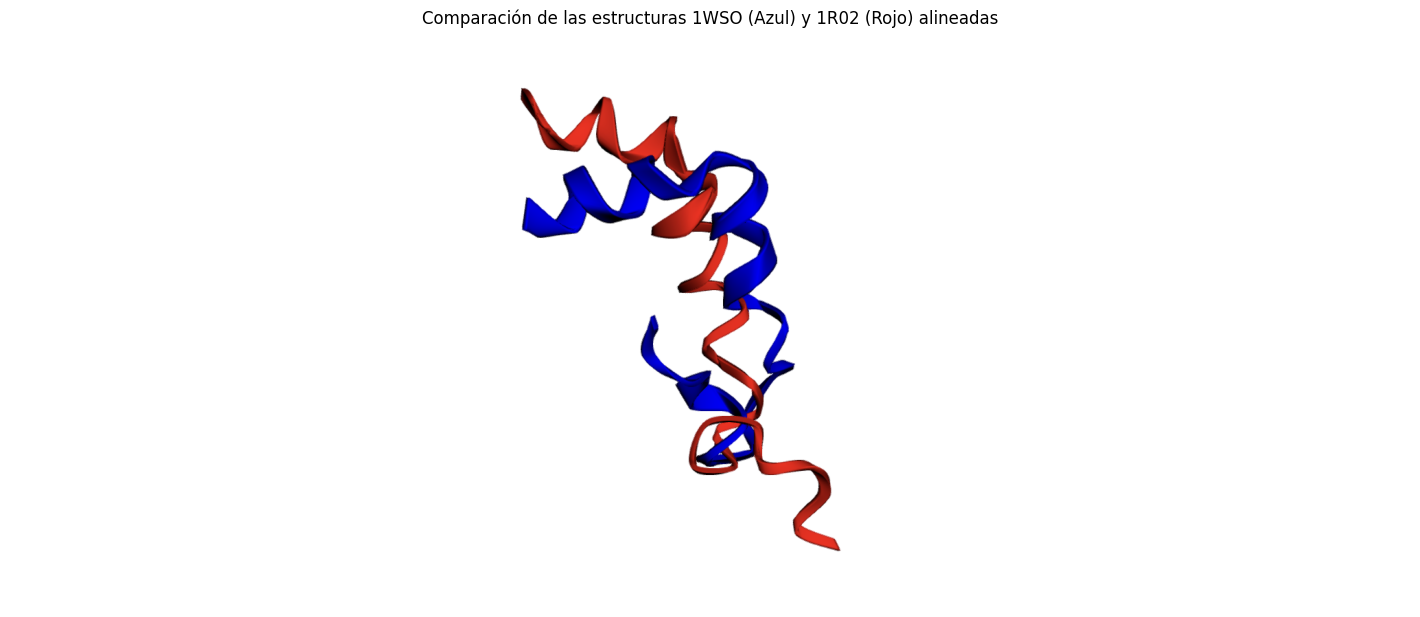

In [168]:
plt.figure(figsize=(14, 8))

img = mpimg.imread("results/comp_1r02.png")
plt.imshow(img)
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.title("Comparación de las estructuras 1WSO (Azul) y 1R02 (Rojo) alineadas")
plt.show()

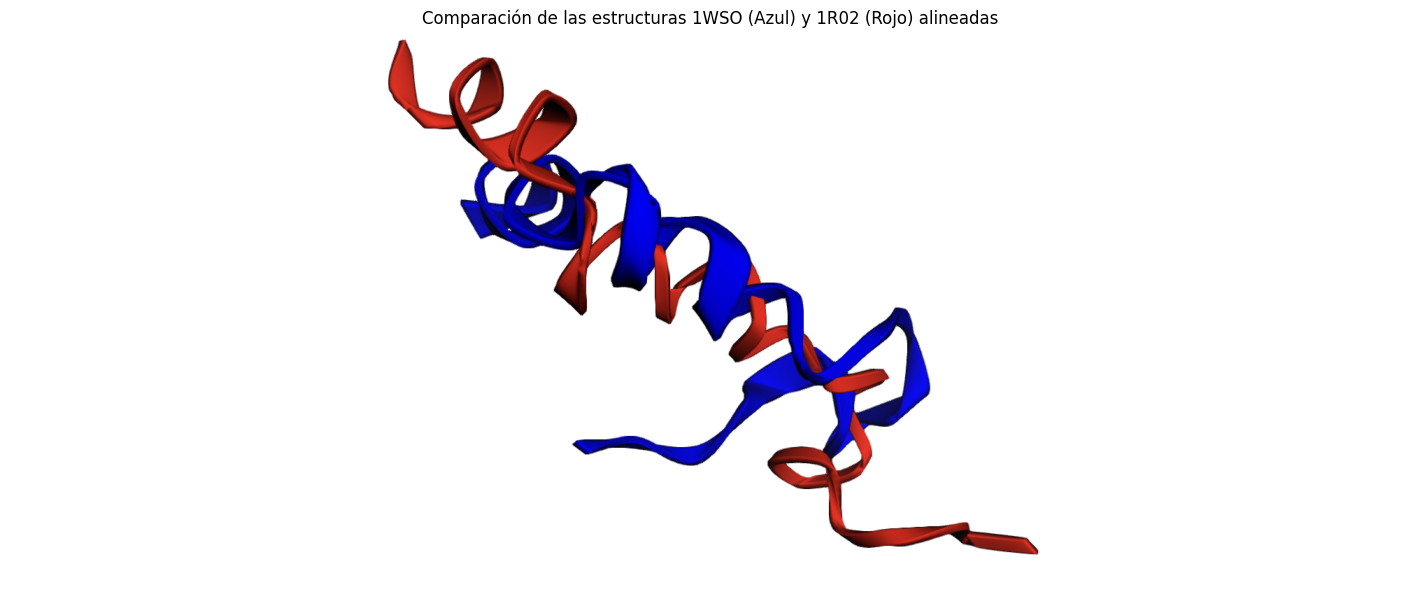

In [169]:
plt.figure(figsize=(14, 8))

img = mpimg.imread("results/comp_1r02_pic2.png")
plt.imshow(img)
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.title("Comparación de las estructuras 1WSO (Azul) y 1R02 (Rojo) alineadas")
plt.show()

Como podemos ver en ambas imágenes, el alineamiento de las estructuras de las proteínas 1WSO (Orexina-A) y 1R02 revela una notable superposición en sus regiones centrales, particularmente en las hélices alfa principales. Esta conservación estructural sugiere que ambas proteínas comparten funciones similares o interacciones comunes en el contexto biológico. Sin embargo, también se observan divergencias en las regiones más flexibles o terminales, donde las cadenas muestran diferencias significativas en su orientación espacial. Estas variaciones podrían estar asociadas con adaptaciones funcionales específicas de cada proteína, reflejando diferencias en su papel biológico o en su interacción con otras moléculas.

Las funciones de las proteínas Orexina-A (1WSO) y 1R02 están relacionadas con su estructura tridimensional, ya que las regiones conservadas, como las hélices alfa principales, son críticas para su actividad biológica. La Orexina-A es un neuropéptido clave en la regulación del sueño-vigilia, el apetito y la homeostasis energética. Su estructura le permite interactuar con receptores específicos de orexina (OX1R y OX2R) distribuidos en el cerebro, lo que resulta esencial para mantener el estado de alerta y regular comportamientos alimenticios. El resultado obtenido afirma que podría que la cadena 1R02 podría compartir algunas de estas funciones, pero sus diferencias estructurales, especialmente en las regiones terminales, podrían reflejar una especialización funcional diferente o una afinidad alterada hacia sus moléculas objetivo.

Estas diferencias estructurales pueden ser determinantes para la interacción con otras proteínas o receptores, modulando su actividad biológica. Por ejemplo, las variaciones en las regiones terminales podrían influir en la estabilidad de la proteína, en su reconocimiento por parte de otras moléculas o en su capacidad para adaptarse a diferentes condiciones fisiológicas. Este tipo de especialización funcional es frecuente en proteínas relacionadas evolutivamente, donde la conservación de regiones críticas asegura funciones esenciales, mientras que las diferencias permiten adaptarse a contextos biológicos específicos.

- **Orexina-B/Hipocretina-2 (1CQ0)**

A continuación, repetiremos el proceso realizado previamente para la Orexina-A/Hipocretina-1 (1WSO) con la Orexina-B/Hipocretina-2 (1CQ0). Este análisis nos permitirá identificar homólogos de la Orexina-B en la base de datos de proteínas no redundantes (NR) y comparar sus estructuras y funciones con la proteína de referencia.

In [118]:
df_homolog_1cq0 = search_online_sequences(sequence_1cq0)

In [119]:
df_homolog_1cq0 = df_homolog_1cq0.sort_values(by="E-value", ascending=True)
df_homolog_1cq0.head(10)

,Organismo,Secuencia,E-value,Score
0,"pdb|1CQ0|A Chain A, PROTEIN (NEW HYPOTHALAMIC ...",28,9.992150e-10,137.0
1,"pdb|7L1U|L Chain L, Orexin [Homo sapiens]",27,1.223360e-08,130.0
2,ref|XP_004472501.2| hypocretin neuropeptide pr...,27,6.113300e-08,132.0
3,ref|XP_059938571.1| hypocretin neuropeptide pr...,27,6.466300e-08,131.0
4,ref|NP_001515.1| hypocretin neuropeptide precu...,27,6.898240e-08,131.0
5,gb|EHH24980.1| Hypocretin [Macaca mulatta],27,7.048540e-08,131.0
6,ref|XP_001166578.1| hypocretin neuropeptide pr...,27,7.064070e-08,131.0
7,ref|XP_032019539.1| hypocretin neuropeptide pr...,27,7.124910e-08,131.0
8,ref|XP_029785099.1| orexin [Suricata suricatta],27,7.124910e-08,131.0
9,ref|XP_011723408.1| orexin [Macaca nemestrina],27,7.359010e-08,131.0


In [132]:
orexin_b_ids = []
for organism in df_homolog_1cq0["Organismo"].head(10):
    print(organism)
    orexin_b_ids.append(organism.split("|")[1])

pdb|1CQ0|A Chain A, PROTEIN (NEW HYPOTHALAMIC NEUROPEPTIDE/OREXIN-B28) [Homo sapiens]
pdb|7L1U|L Chain L, Orexin [Homo sapiens]
ref|XP_004472501.2| hypocretin neuropeptide precursor [Dasypus novemcinctus]
ref|XP_059938571.1| hypocretin neuropeptide precursor [Mesoplodon densirostris]
ref|NP_001515.1| hypocretin neuropeptide precursor precursor [Homo sapiens] >ref|XP_003813923.1| hypocretin neuropeptide precursor [Pan paniscus] >ref|XP_063562471.1| hypocretin neuropeptide precursor [Gorilla gorilla gorilla] >sp|O43612.1| RecName: Full=Hypocretin neuropeptide precursor; AltName: Full=Hypocretin; Short=Hcrt; AltName: Full=Orexin precursor; AltName: Full=Prepro-orexin; AltName: Full=Preprohypocretin; Contains: RecName: Full=Orexin-A; AltName: Full=Hypocretin-1; Short=Hcrt1; Contains: RecName: Full=Orexin-B; AltName: Full=Hypocretin-2; Short=Hcrt2; Flags: Precursor [Homo sapiens] >gb|AAI11916.1| HCRT protein, partial [synthetic construct] >gb|AAC39600.1| prepro-orexin [Homo sapiens] >gb|AAD

In [121]:
filtered_homologs_1cq0 = df_homolog_1cq0[df_homolog_1cq0["Organismo"].str.contains("Homo sapiens", na=False)]
for organism in filtered_homologs_1cq0["Organismo"].head(10):
    print(organism)

pdb|1CQ0|A Chain A, PROTEIN (NEW HYPOTHALAMIC NEUROPEPTIDE/OREXIN-B28) [Homo sapiens]
pdb|7L1U|L Chain L, Orexin [Homo sapiens]
ref|NP_001515.1| hypocretin neuropeptide precursor precursor [Homo sapiens] >ref|XP_003813923.1| hypocretin neuropeptide precursor [Pan paniscus] >ref|XP_063562471.1| hypocretin neuropeptide precursor [Gorilla gorilla gorilla] >sp|O43612.1| RecName: Full=Hypocretin neuropeptide precursor; AltName: Full=Hypocretin; Short=Hcrt; AltName: Full=Orexin precursor; AltName: Full=Prepro-orexin; AltName: Full=Preprohypocretin; Contains: RecName: Full=Orexin-A; AltName: Full=Hypocretin-1; Short=Hcrt1; Contains: RecName: Full=Orexin-B; AltName: Full=Hypocretin-2; Short=Hcrt2; Flags: Precursor [Homo sapiens] >gb|AAI11916.1| HCRT protein, partial [synthetic construct] >gb|AAC39600.1| prepro-orexin [Homo sapiens] >gb|AAD24459.1| prepro-orexin [Homo sapiens] >gb|EAW60810.1| hypocretin (orexin) neuropeptide precursor [Homo sapiens] >gb|KAI2583060.1| hypocretin neuropeptide pre

Hemos encontrado que la proteína 7L1U, en su cadena L, es un homólogo de la Orexina-B/Hipocretina-2 (1CQ0). Así, nos descargaremos el fichero fasta de la misma y la alinearemos, de manera similar a como hicimos con la Orexina-A/Hipocretina-1 (1WSO).

In [122]:
parser = PDB.PDBParser()
structure_1wso = parser.get_structure("1CQ0", data_path + "/1cq0.pdb")
structure_7l1u = parser.get_structure("7L1U", data_path + "/7l1u.pdb")

In [212]:
atomic_aligner = Superimposer()
atomic_aligner.align(structure_1wso, structure_7l1u, chain1_id="A", chain2_id="L")

(array([[-0.84574812, -0.14445522, -0.51365632],
       [ 0.53026314, -0.33475039, -0.77895005],
       [-0.05942325, -0.93116855,  0.35971379]]), array([ 36.66026179, 219.51549207, 100.41673578]))
RMSD: 4.028924805416666


In [213]:
io = PDB.PDBIO()
io.set_structure(structure_1wso)
io.save(data_path + "/1wso_aligned.pdb")

io.set_structure(structure_7l1u)
io.save(data_path + "/7l1u_aligned.pdb")

Si visualizamos los resultados, obtenemos lo siguiente:

In [ ]:
view = py3Dmol.view(width=1400, height=600)

with open(data_path + "/1wso_aligned.pdb", "r") as f1:
    view.addModel(f1.read(), "pdb")
    view.setStyle({"model": 0}, {"cartoon": {"color": "blue"}})

with open(data_path + "/7l1u_aligned.pdb", "r") as f2:
    view.addModel(f2.read(), "pdb")
    view.setStyle({"model": 1, "chain": "L"}, {"cartoon": {"color": "red"}})

view.zoomTo()
view.show()

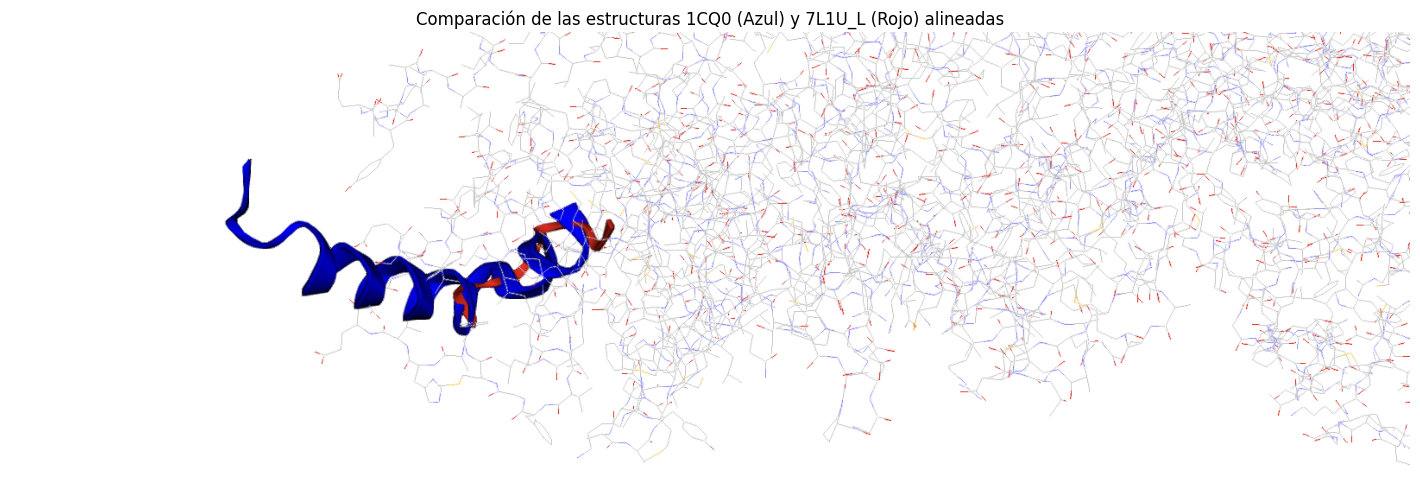

In [170]:
plt.figure(figsize=(14, 8))

img = mpimg.imread("results/comp_7l1u_pic1.png")
plt.imshow(img)
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.title("Comparación de las estructuras 1CQ0 (Azul) y 7L1U_L (Rojo) alineadas")
plt.show()

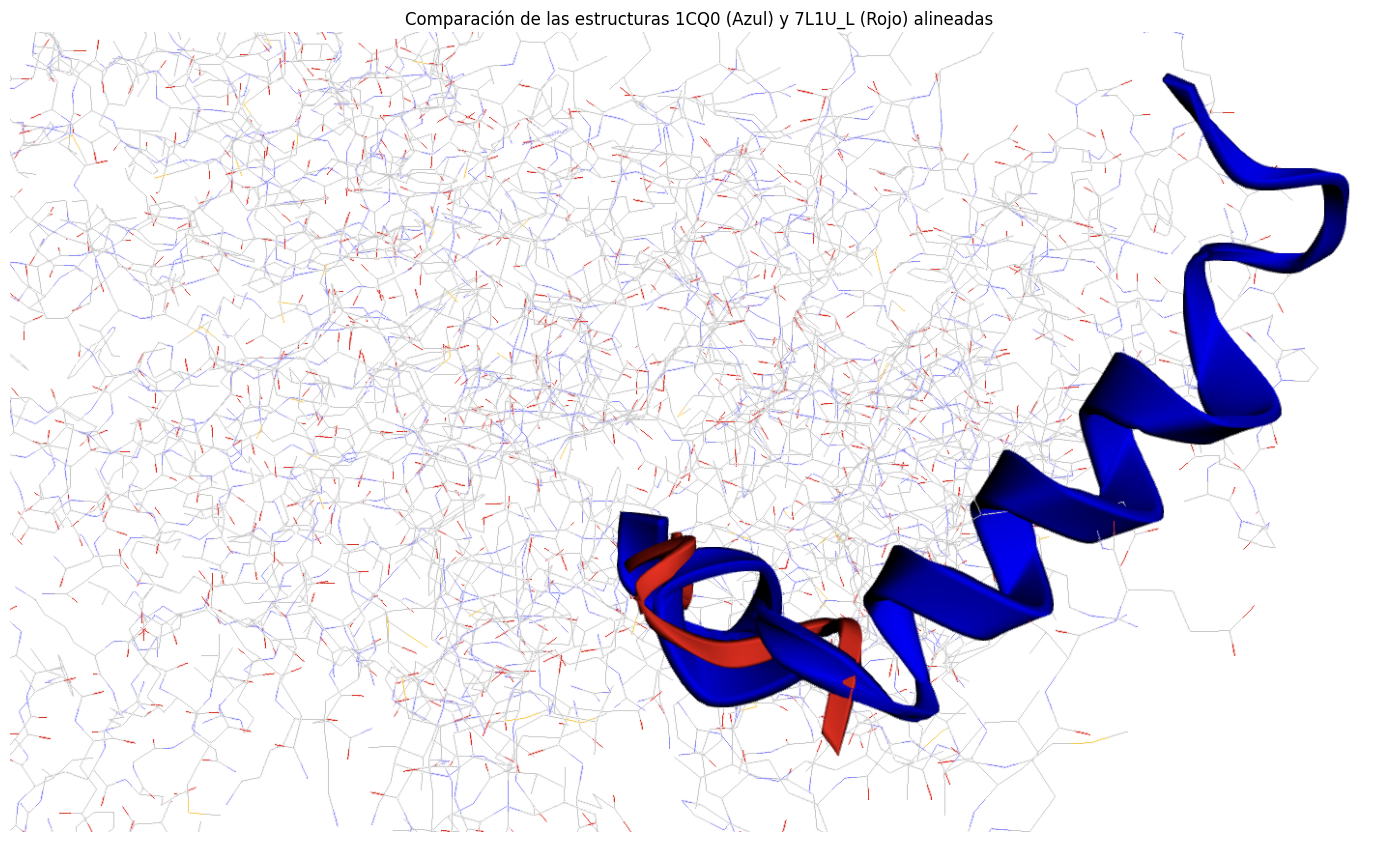

In [171]:
plt.figure(figsize=(14, 8))

img = mpimg.imread("results/comp_7l1u_pic2.png")
plt.imshow(img)
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.title("Comparación de las estructuras 1CQ0 (Azul) y 7L1U_L (Rojo) alineadas")
plt.show()

Como se puede apreciar, la superposición de las estructuras de la Orexina-B/Hipocretina-2 (1CQ0) y su homólogo 7L1U revela una alineación significativa en las regiones centrales de las proteínas, especialmente en las hélices alfa principales. No obstante, esta superposición tan solo ocurre con la cadena L de la proteína 7L1U. El resto del area mostrada en la figura se corresponde a las demás cadenas de la proteína 7L1U, las cuales no se han alineado con la Orexina-B/Hipocretina-2 (1CQ0).

### Construcción de árboles filogenéticos

Primero, generaremos los ficheros fasta necesarios, accediendo para ello a NCBI y seleccionando todas las proteínas necesarias para exportarlas en formato fasta. Una vez hecho esto, procederemos a la construcción de los árboles filogenéticos.

Una vez generados los ficheros fasta, procedemos a realizar la construcción de los árboles filogenéticos. Para ello, utilizaremos la herramienta CLUSTAL Omega, la cual es una herramienta de alineamiento múltiple de secuencias que permite comparar y alinear secuencias de proteínas o ADN. En este caso, utilizaremos CLUSTAL Omega para alinear las secuencias de las proteínas de interés y construir un árbol filogenético que muestre su relación evolutiva.

In [51]:
fasta_file = "sequences/combined_orexin_a.fasta"

aligned_file = "sequences/combined_orexin_a_aligned.fasta"
clustalomega_cline = ClustalOmegaCommandline(infile=fasta_file, outfile=aligned_file, verbose=True, auto=True, force=True)
clustalomega_cline()

('Using 1 threads\nRead 10 sequences (type: Protein) from sequences/combined_orexin_a.fasta\nnot more sequences (10) than cluster-size (100), turn off mBed\nSetting options automatically based on input sequence characteristics (might overwrite some of your options).\nAuto settings: Enabling mBed.\nAuto settings: Setting iteration to 1.\nUsing 9 seeds (chosen with constant stride from length sorted seqs) for mBed (from a total of 10 sequences)\nCalculating pairwise ktuple-distances...\nKtuple-distance calculation progress: 0 % (0 out of 54)\nKtuple-distance calculation progress: 16 % (9 out of 54)\nKtuple-distance calculation progress: 31 % (17 out of 54)\nKtuple-distance calculation progress: 44 % (24 out of 54)\nKtuple-distance calculation progress: 55 % (30 out of 54)\nKtuple-distance calculation progress: 64 % (35 out of 54)\nKtuple-distance calculation progress: 72 % (39 out of 54)\nKtuple-distance calculation progress: 77 % (42 out of 54)\nKtuple-distance calculation progress: 81 

Una vez realizado el alineamiento, procedemos a la construcción del árbol filogenético utilizando el método Neighbor Joining. Este método es un algoritmo de agrupamiento jerárquico que se basa en la construcción de un árbol filogenético a partir de una matriz de distancias entre las secuencias. El algoritmo comienza con un árbol no resuelto y, en cada paso, agrupa las secuencias más cercanas en un nodo interno, actualizando las distancias entre los nodos restantes. Este proceso se repite hasta que todas las secuencias se agrupan en un único nodo raíz, generando un árbol que representa la relación evolutiva entre las secuencias.

In [52]:
alignment = AlignIO.read(aligned_file, "fasta")

calculator = DistanceCalculator("identity")
distance_matrix = calculator.get_distance(alignment)

constructor = DistanceTreeConstructor(calculator, method="nj")
tree = constructor.build_tree(alignment)

Por último, aplicaremos ligeras modificaciones en el árbol para que sea más legible y fácil de interpretar. Estas modificaciones incluyen la adición de etiquetas a los nodos y ramas. El resultado final es un árbol filogenético que muestra la relación evolutiva entre las proteínas de interés y otros homólogos identificados en la base de datos.

In [53]:
def analyze_tree(tree):    
    num_terminals = len(tree.get_terminals())
    num_clades = len(list(tree.find_clades()))
    branch_lengths = [clade.branch_length for clade in tree.find_clades() if clade.branch_length is not None]
    terminal_names = [terminal.name for terminal in tree.get_terminals()]
    
    clades_with_bootstrap = [(clade.confidence, clade) for clade in tree.find_clades() if clade.confidence is not None]
    best_bootstrap, best_clade = (None, None)
    if clades_with_bootstrap:
        best_bootstrap, best_clade = max(clades_with_bootstrap, key=lambda x: x[0])
    
    min_distance, closest_pair = float('inf'), None
    for (name1, name2) in combinations(terminal_names, 2):
        distance = tree.distance(name1, name2)
        if distance < min_distance:
            min_distance = distance
            closest_pair = (name1, name2)
    
    max_distance, most_distant_species = float('-inf'), None
    for name in terminal_names:
        distance = tree.distance(tree.root, name)
        if distance > max_distance:
            max_distance = distance
            most_distant_species = name

    print(f"Información del árbol filogenético:")
    print(f"Número de terminales: {num_terminals}")
    print(f"Número de nodos/clados totales: {num_clades}")
    print(f"Longitudes de las ramas: {branch_lengths}")
    print(f"Nombres de terminales: {terminal_names}")
    
    if best_clade:
        print(f"Clado con el mejor bootstrap: {best_bootstrap}")
    if closest_pair:
        print(f"Especies más parecidas: {closest_pair} con distancia {min_distance}")
    if most_distant_species:
        print(f"Especie más distante desde la raíz: {most_distant_species} con distancia {max_distance}")
    
    return closest_pair, most_distant_species

In [54]:
def branch_label_func(clade):
        if clade.branch_length is not None:
            return f"{clade.branch_length:.2f}"
        return ""

def plot_tree(tree, branch_width=2, title="Árbol filogenético"):
    plt.figure(figsize=(25, 12))
    ax = plt.gca()

    Phylo.draw(
        tree,
        axes=ax,
        branch_labels=branch_label_func,
        do_show=False
    )

    for line in ax.findobj(match=lambda obj: isinstance(obj, plt.Line2D)):
        line.set_linewidth(branch_width)

    plt.title(title)
    plt.axis("off")
    plt.show()


In [55]:
closest_pair, most_distant_species = analyze_tree(tree)

Información del árbol filogenético:
Número de terminales: 10
Número de nodos/clados totales: 18
Longitudes de las ramas: [0, 0.05415076335877861, 0.12142175572519087, 0.09319338422391854, 0.05184478371501272, 0.04143947655398034, 0.0348964013086151, 0.07514312977099233, 0.039360687022900756, 0.010734732824427516, 0.0512881679389313, 0.05916030534351145, 0.11564885496183211, 0.22041984732824427, 0.03912213740458015, 0.12862595419847325, 0.036259541984732815, 0.023139312977099202]
Nombres de terminales: ['XP_004390402.1', 'XP_047400177.1', 'XP_015351183.2', 'XP_003467169.1', 'BAV60975.1', 'pdb|1WSO|A', 'AAL17613.1', 'XP_016057502.1', 'AOY33875.1', 'BAB91446.1']
Especies más parecidas: ('BAV60975.1', 'BAB91446.1') con distancia 0.07323473282442747
Especie más distante desde la raíz: pdb|1WSO|A con distancia 0.4572519083969466


In [58]:
def parse_fasta(file):
    protein_dict = {}
    with open(file, 'r') as f:
        for line in f:
            if line.startswith('>'):
                parts = line[1:].split(' ', 1)
                protein_id = parts[0]
                protein_name = parts[1].strip() if len(parts) > 1 else ''
                protein_dict[protein_id] = protein_name
    return protein_dict

def modify_tree(tree, file):
    protein_names = parse_fasta(file)

    for clade in tree.find_clades():
        if clade.name == 'pdb|1WSO|A':
            clade.color = 'blue'

        if clade.name in protein_names:
            clade.name = f'({clade.name}) {protein_names[clade.name]}'

    return tree


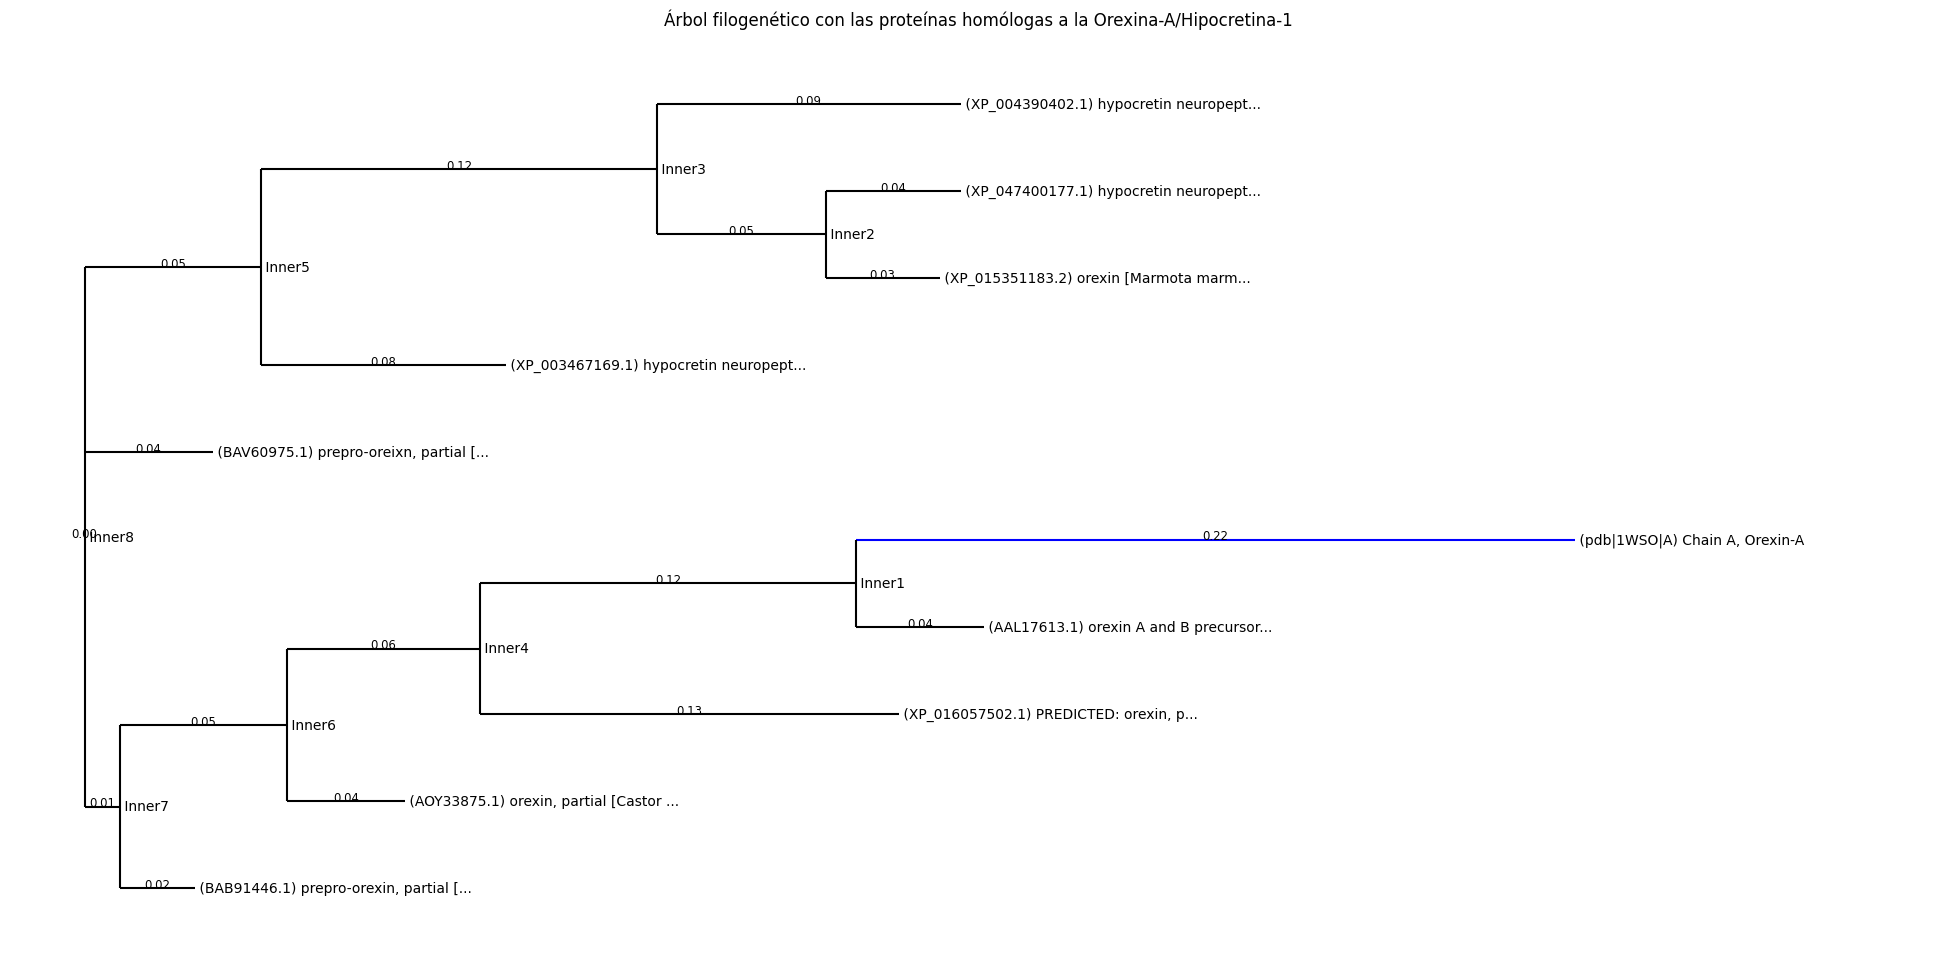

In [59]:
modified_tree = modify_tree(tree, "sequences/combined_orexin_a.fasta")
plot_tree(modified_tree, title='Árbol filogenético con las proteínas homólogas a la Orexina-A/Hipocretina-1')

Podemos ver cómo la proteína más cercana a 1WSO según este árbol filogenético es la Orexina A y B precursora de la especie Ovis aries, pese a tener un menor E-value que la de la especie Miniopterus natalensis. Ahora bien, puede ser que esto dependa del método de alineamiento utilizado, por lo que es importante tener en cuenta que los resultados pueden variar según el algoritmo y los parámetros seleccionados. Usaremos ahora el método UPGMA, acrónimo de Unweighted Pair Group Method with Arithmetic Mean, para construir un nuevo árbol filogenético.

In [60]:
alignment = AlignIO.read(aligned_file, "fasta")

calculator = DistanceCalculator("identity")
distance_matrix = calculator.get_distance(alignment)

constructor = DistanceTreeConstructor(calculator, method="upgma")
tree = constructor.build_tree(alignment)

In [61]:
closest_pair, most_distant_species = analyze_tree(tree)

Información del árbol filogenético:
Número de terminales: 10
Número de nodos/clados totales: 19
Longitudes de las ramas: [0, 0.1682669370229008, 0.09160305343511449, 0.05343511450381677, 0.03816793893129772, 0.03816793893129772, 0.10672113549618323, 0.07144561068702293, 0.1297709923664122, 0.1297709923664122, 0.04806774809160308, 0.053912213740458015, 0.09923664122137404, 0.03625954198473283, 0.028625954198473275, 0.03435114503816794, 0.03435114503816794, 0.06297709923664122, 0.15314885496183206]
Nombres de terminales: ['XP_004390402.1', 'XP_047400177.1', 'XP_015351183.2', 'pdb|1WSO|A', 'AAL17613.1', 'XP_003467169.1', 'BAV60975.1', 'BAB91446.1', 'AOY33875.1', 'XP_016057502.1']
Especies más parecidas: ('BAV60975.1', 'BAB91446.1') con distancia 0.06870229007633588
Especie más distante desde la raíz: pdb|1WSO|A con distancia 0.30793773854961837


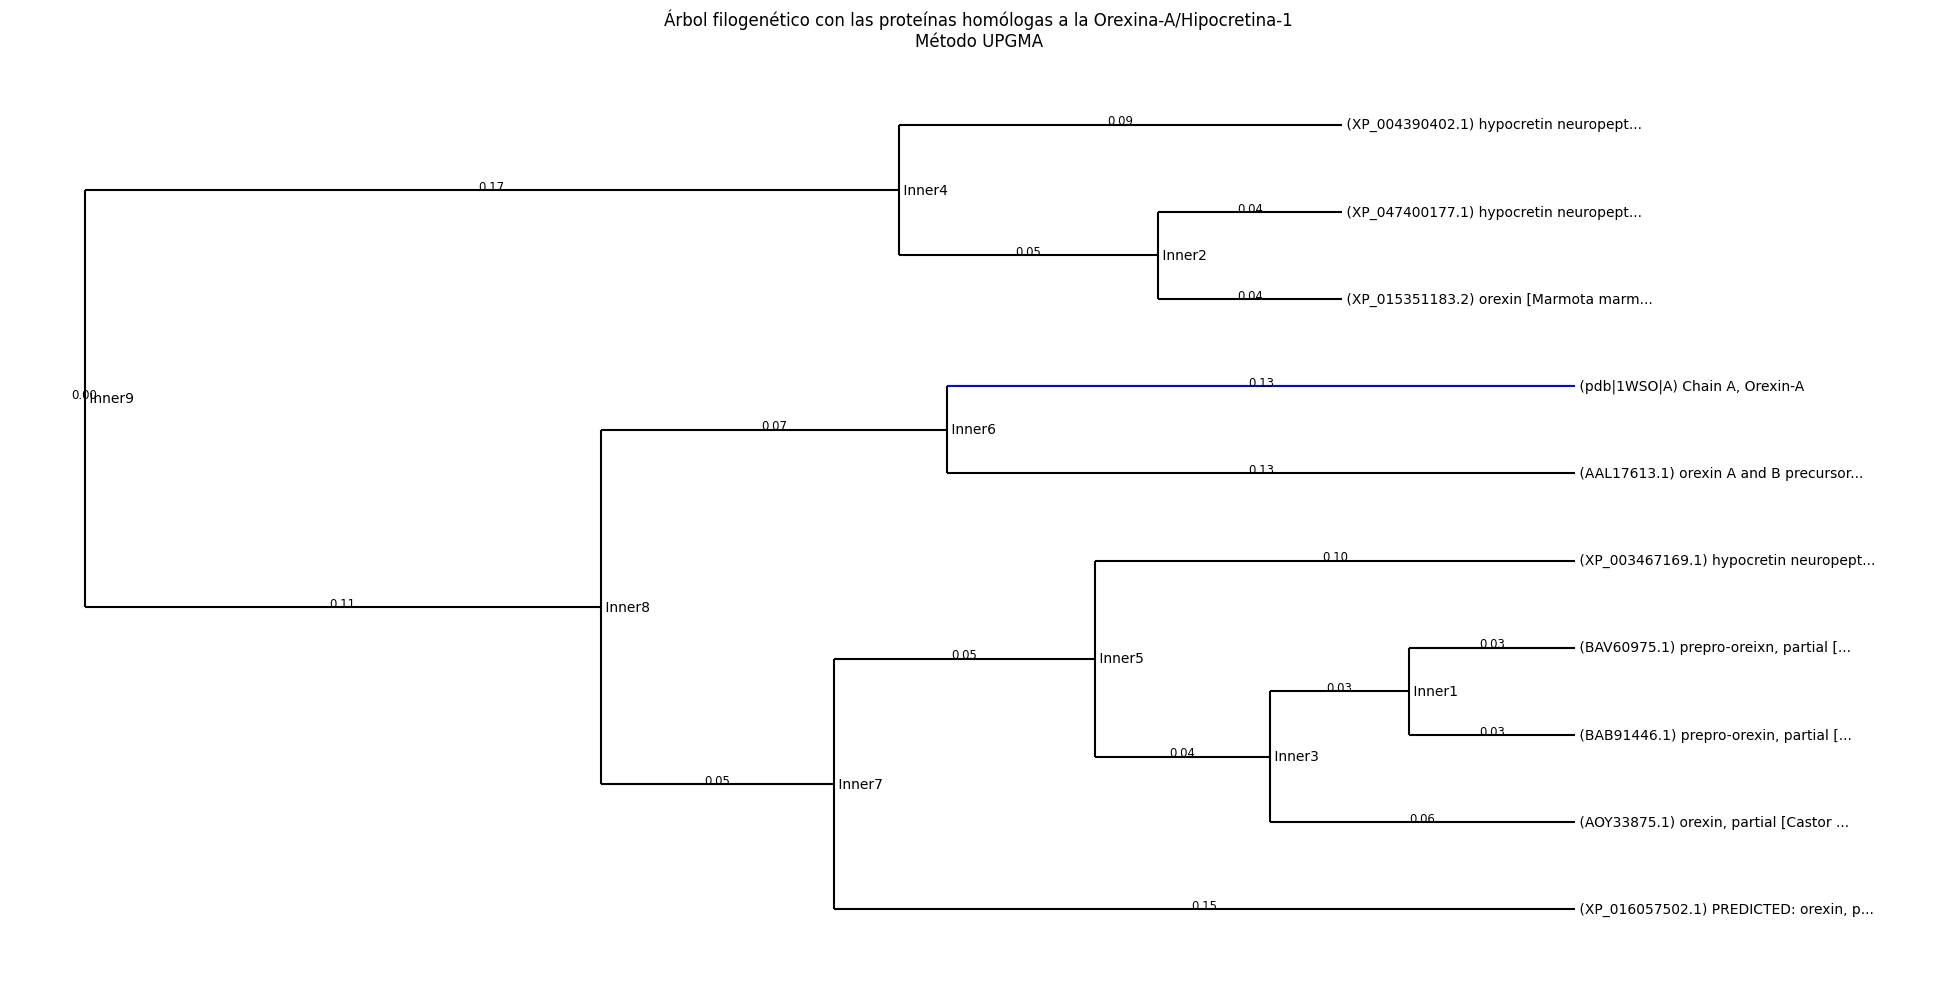

In [63]:
modified_tree = modify_tree(tree, "sequences/combined_orexin_a.fasta")
plot_tree(modified_tree, title='Árbol filogenético con las proteínas homólogas a la Orexina-A/Hipocretina-1\nMétodo UPGMA')

Se vuelve a tener el mismo resultado, con la proteína más cercana a 1WSO siendo la Orexina A y B precursora de la especie Ovis aries. Esto sugiere que la Orexina A y B de esta especie es la más cercana a la Orexina A/Hipocretina-1 (1WSO) en términos evolutivos, lo que puede tener implicaciones en la conservación de la estructura y función de estas proteínas en mamíferos.

Ahora generaremos el árbol filogenético para la Orexina-B/Hipocretina-2 (1CQ0).

In [64]:
fasta_file = "sequences/combined_orexin_b.fasta"

aligned_file = "sequences/combined_orexin_b_aligned.fasta"
clustalomega_cline = ClustalOmegaCommandline(infile=fasta_file, outfile=aligned_file, verbose=True, auto=True, force=True)
clustalomega_cline()

('Using 1 threads\nRead 10 sequences (type: Protein) from sequences/combined_orexin_b.fasta\nnot more sequences (10) than cluster-size (100), turn off mBed\nSetting options automatically based on input sequence characteristics (might overwrite some of your options).\nAuto settings: Enabling mBed.\nAuto settings: Setting iteration to 1.\nUsing 9 seeds (chosen with constant stride from length sorted seqs) for mBed (from a total of 10 sequences)\nCalculating pairwise ktuple-distances...\nKtuple-distance calculation progress: 0 % (0 out of 54)\nKtuple-distance calculation progress: 16 % (9 out of 54)\nKtuple-distance calculation progress: 31 % (17 out of 54)\nKtuple-distance calculation progress: 44 % (24 out of 54)\nKtuple-distance calculation progress: 55 % (30 out of 54)\nKtuple-distance calculation progress: 64 % (35 out of 54)\nKtuple-distance calculation progress: 72 % (39 out of 54)\nKtuple-distance calculation progress: 77 % (42 out of 54)\nKtuple-distance calculation progress: 81 

In [65]:
alignment = AlignIO.read(aligned_file, "fasta")

calculator = DistanceCalculator("identity")
distance_matrix = calculator.get_distance(alignment)

constructor = DistanceTreeConstructor(calculator, method="nj")
tree = constructor.build_tree(alignment)

In [66]:
closest_pair, most_distant_species = analyze_tree(tree)

Información del árbol filogenético:
Número de terminales: 10
Número de nodos/clados totales: 18
Longitudes de las ramas: [0, 0.004464285714285719, 0.020911654135338326, 0.02044172932330829, 0.005907626208378078, 0.009129967776584327, 0.007753759398496263, 0.014285714285714249, 0.012030075187969932, 0.003132832080200529, 0.004385964912280729, 0.008693609022556364, 0.7182017543859649, 0.011278195488721943, 0.0037593984962404625, 0.059993734335839655, 0.036654135338345877, 0.038533834586466156]
Nombres de terminales: ['XP_011723408.1', 'EHH24980.1', 'XP_032019539.1', 'XP_001166578.1', 'NP_001515.1', 'pdb|1CQ0|A', 'pdb|7L1U|L', 'XP_004472501.2', 'XP_059938571.1', 'XP_029785099.1']
Especies más parecidas: ('XP_001166578.1', 'NP_001515.1') con distancia 0.007518796992481258
Especie más distante desde la raíz: pdb|1CQ0|A con distancia 0.7426378446115289


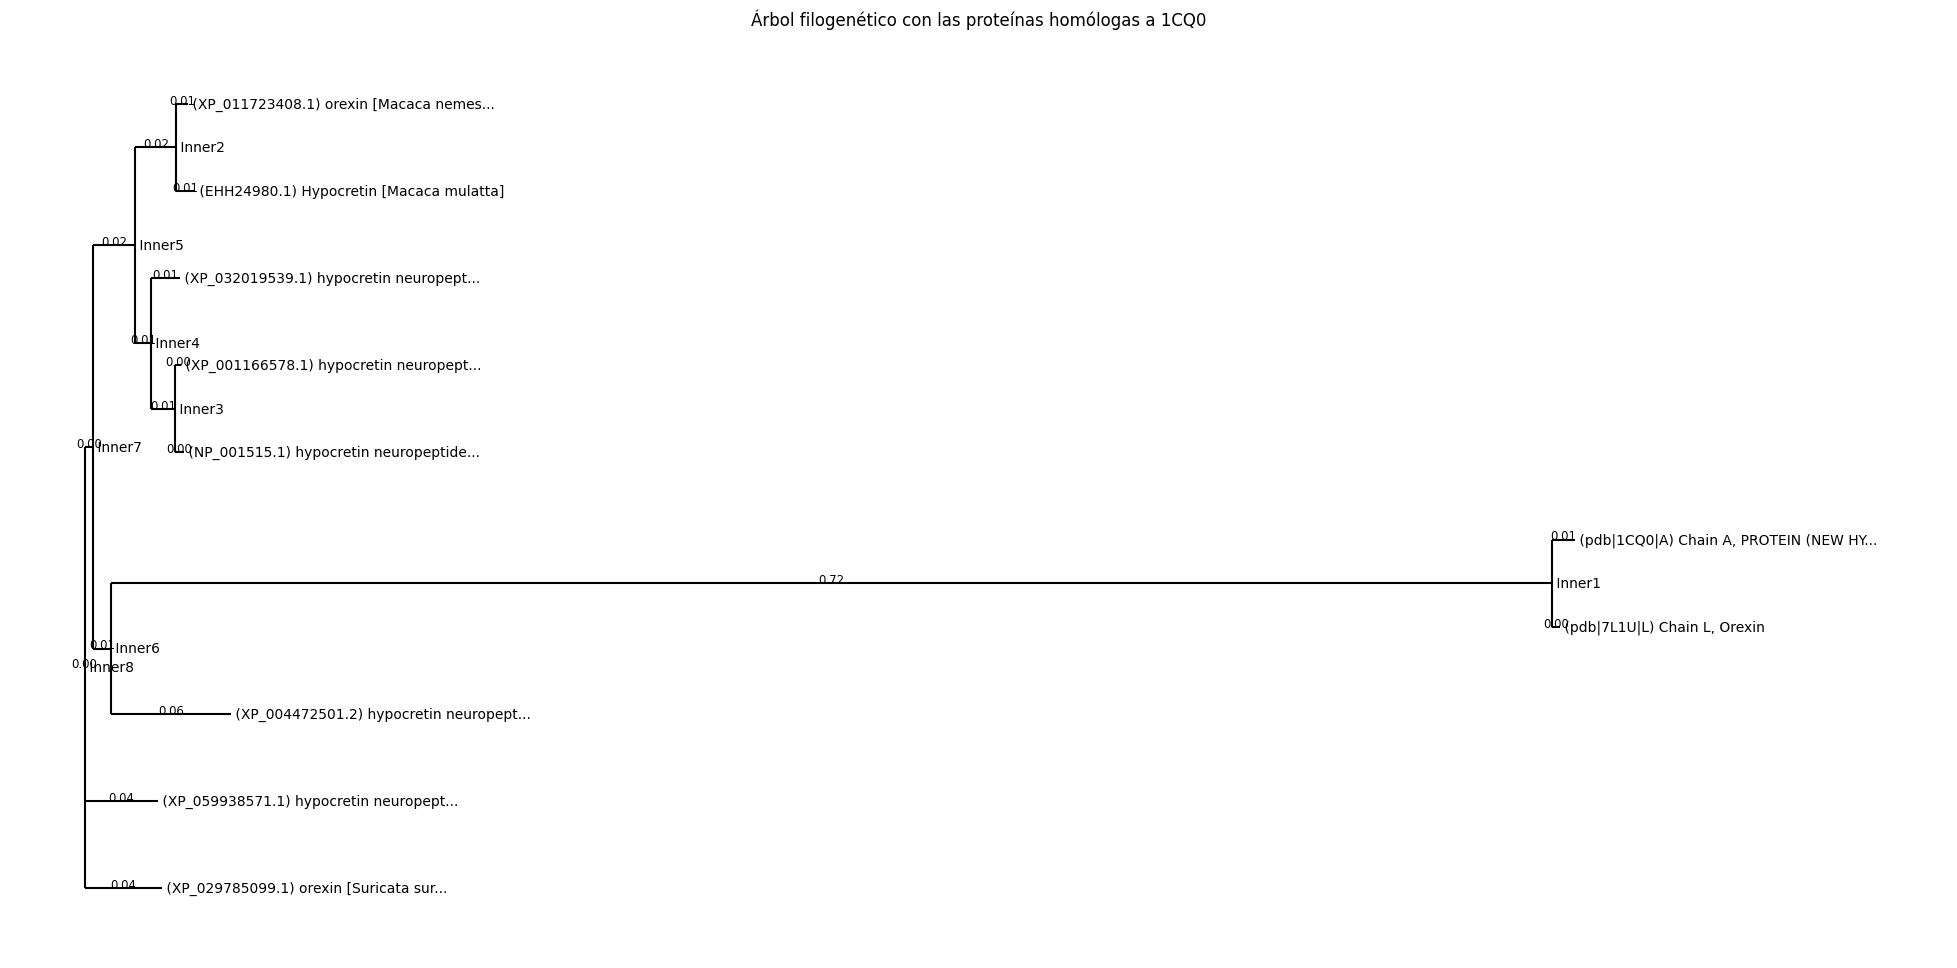

In [67]:
modified_tree = modify_tree(tree, "sequences/combined_orexin_b.fasta")
plot_tree(modified_tree, title='Árbol filogenético con las proteínas homólogas a 1CQ0')

En este caso, sí que obtenemos que el homólogo más cercano a la Orexina-B/Hipocretina-2 (1CQ0) es la cadena L de la Orexina del Homo Sapiens (7L1U), que era lo que se esperaba.

### Máximas distancias entre átomos

Por último, definiremos una función, `max_distance_between_atoms`, que nos permitirá calcular la máxima distancia entre los átomos de una estructura concreta. Para ello, tenemos en cuenta que la librería `Bio.PDB` de Biopython nos permite acceder a las coordenadas de los átomos de una proteína, y que la distancia entre dos puntos en un espacio tridimensional se puede calcular mediante la fórmula de la distancia euclidiana.

(*) Algo importante a tener en cuenta es que la libería `Bio` permite calcular la distancia euclidea entre dos átomos, `atom1`y `atom2`, mediante la función `atom1 - atom2`. Esto es, la diferencia entre las coordenadas de los dos átomos es equivalente a la distancia euclidea entre ellos, dada por

$$
\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}
$$

siendo $(x_1, y_1, z_1)$ y $(x_2, y_2, z_2)$ las coordenadas en un espacio tridimensional de los átomos `atom1` y `atom2`, respectivamente.

In [147]:
def max_distance_between_atoms(structure):
    atoms = list(structure.get_atoms())
    max_distance = 0
    for i, atom1 in enumerate(atoms):
        for atom2 in atoms[i+1:]:
            distance = atom1 - atom2
            if distance > max_distance:
                max_distance = distance
    return max_distance

Calcularemos la máxima distancia entre átomos para las dos estructuras de proteínas que estamos estudiando, Orexina-A/Hipocretina-1 y Orexina-B/Hipocretina-2. El resultado obtenido es el siguiente;

In [150]:
def compare_proteins_max_distance(pdb_file1, pdb_file2):
    parser = PDB.PDBParser(QUIET=True)

    structure1 = parser.get_structure("Protein1", pdb_file1)
    structure2 = parser.get_structure("Protein2", pdb_file2)

    max_distance1 = max_distance_between_atoms(structure1)
    max_distance2 = max_distance_between_atoms(structure2)

    if max_distance1 > max_distance2:
        return f"La proteína del archivo '{pdb_file1}' tiene la mayor distancia entre átomos: {max_distance1:.2f} Å\nLa proteína del archivo '{pdb_file2}' tiene una distancia máxima entre átomos de {max_distance2:.2f} Å"
    elif max_distance2 > max_distance1:
        return f"La proteína del archivo '{pdb_file2}' tiene la mayor distancia entre átomos: {max_distance2:.2f} Å\nLa proteína del archivo '{pdb_file1}' tiene una distancia máxima entre átomos de {max_distance1:.2f} Å"
    else:
        return f"Ambas proteínas tienen la misma distancia máxima entre átomos: {max_distance1:.2f} Å"


In [151]:
pdb_file1 = data_path + "/1WSO.pdb"
pdb_file2 = data_path + "/1CQ0.pdb"

result = compare_proteins_max_distance(pdb_file1, pdb_file2)
print(result)

La proteína del archivo './data/1WSO.pdb' tiene la mayor distancia entre átomos: 44.66 Å
La proteína del archivo './data/1CQ0.pdb' tiene una distancia máxima entre átomos de 34.73 Å


Esta diferencia entre ambas proteínas era algo que no se apreciaba de una forma tan clara en la representación de ambas proteínas en un mismo espacio. Ahora, ¿por qué puede ser esto?

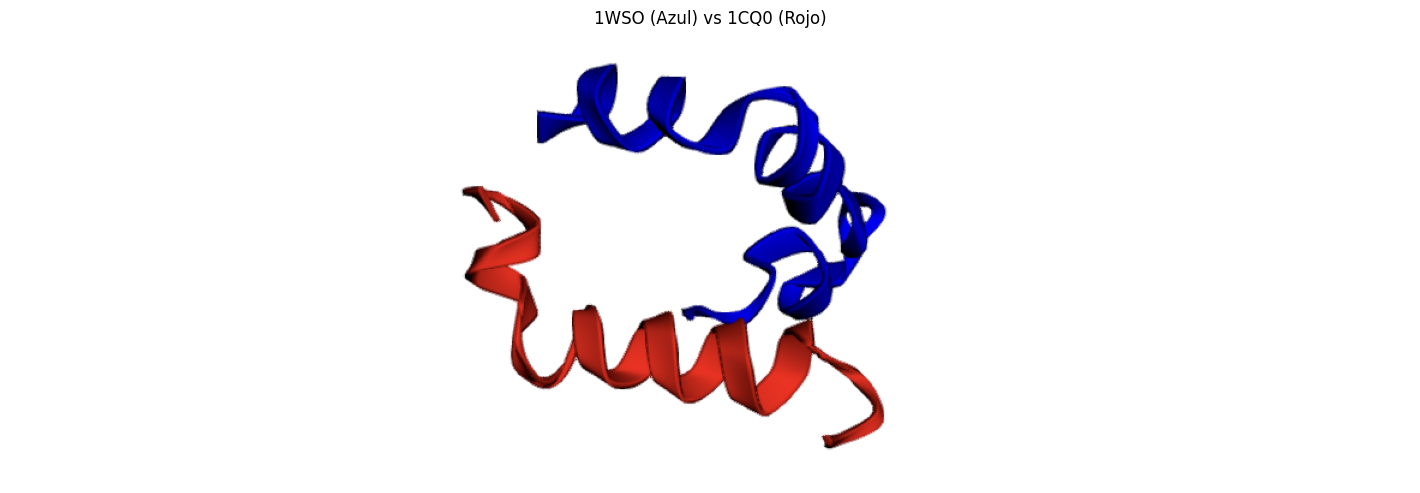

In [154]:
plt.figure(figsize=(14, 5))

img = mpimg.imread("results/comp_pic1.png")
plt.imshow(img)
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.title("1WSO (Azul) vs 1CQ0 (Rojo)")
plt.show()

Si visualizamos cómo se ha calculado esta distancia, calculando esta vez la distancia euclídea de las coordenadas de los átomos para asegurar que el cálculo realizado anteriormente es correcto, vemos como los ligandos encontrados afectan al cálculo de la distancia:

In [30]:
def calculate_distance(coord1, coord2):
    return np.linalg.norm(np.array(coord1) - np.array(coord2))

def max_distance_between_atoms(structure):
    atoms = list(structure.get_atoms())
    max_distance = 0
    atom1_far = None
    atom2_far = None
    for i, atom1 in enumerate(atoms):
        for atom2 in atoms[i + 1:]:
            distance = calculate_distance(atom1.coord, atom2.coord)
            if distance > max_distance:
                max_distance = distance
                atom1_far = atom1
                atom2_far = atom2
    return max_distance, atom1_far, atom2_far

In [50]:
def visualize_max_distance(pdb_file):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("Protein", pdb_file)

    max_distance, atom1, atom2 = max_distance_between_atoms(structure)
    print(f"La distancia máxima entre átomos es: {max_distance:.2f} Å")

    atom1_info = f"Átomo 1: {atom1.name}, Residuo: {atom1.parent.resname} {atom1.parent.id}, Cadena: {atom1.parent.parent.id}"
    atom2_info = f"Átomo 2: {atom2.name}, Residuo: {atom2.parent.resname} {atom2.parent.id}, Cadena: {atom2.parent.parent.id}"
    print(atom1_info)
    print(atom2_info)

    view = py3Dmol.view(width=1400, height=400)

    with open(pdb_file, 'r') as archivo:
        pdb_data = archivo.read()
    view.addModel(pdb_data, 'pdb')

    view.setStyle({'cartoon': {'color': 'white', 'opacity': 0.7}})

    for atom, color in zip([atom1, atom2], ['blue', 'green']):
        view.addSphere({
            'center': {
                'x': float(atom.coord[0]),
                'y': float(atom.coord[1]),
                'z': float(atom.coord[2])
            },
            'radius': 0.5,
            'color': color,
            'opacity': 1.0
        })

    view.addCylinder({
        'start': {'x': float(atom1.coord[0]), 'y': float(atom1.coord[1]), 'z': float(atom1.coord[2])},
        'end': {'x': float(atom2.coord[0]), 'y': float(atom2.coord[1]), 'z': float(atom2.coord[2])},
        'radius': 0.2,
        'color': 'red',
        'opacity': 1.0
    })

    midpoint = [
        float((atom1.coord[0] + atom2.coord[0]) / 2),
        float((atom1.coord[1] + atom2.coord[1]) / 2),
        float((atom1.coord[2] + atom2.coord[2]) / 2)
    ]

    view.addLabel(f"Distancia: {max_distance:.2f} Å", {
        'position': {'x': midpoint[0], 'y': midpoint[1], 'z': midpoint[2]},
        'backgroundColor': 'white',
        'fontColor': 'black',
        'fontSize': 14,
        'showBackground': True
    })

    view.addLabel(atom1_info, {
        'position': {'x': float(atom1.coord[0]), 'y': float(atom1.coord[1]), 'z': float(atom1.coord[2])},
        'backgroundColor': 'blue',
        'fontColor': 'white',
        'fontSize': 12,
        'showBackground': True
    })

    view.addLabel(atom2_info, {
        'position': {'x': float(atom2.coord[0]), 'y': float(atom2.coord[1]), 'z': float(atom2.coord[2])},
        'backgroundColor': 'green',
        'fontColor': 'white',
        'fontSize': 12,
        'showBackground': True
    })

    view.setBackgroundColor('white')
    view.zoomTo()
    view.show()

In [83]:
pdb_file_path = "./data/1WSO.pdb"
visualize_max_distance(pdb_file_path)

end=La distancia máxima entre átomos es: 44.66 Å
Átomo 1: HD22, Residuo: LEU (' ', 33, ' '), Cadena: A
Átomo 2: HZ3, Residuo: LYS (' ', 10, ' '), Cadena: A


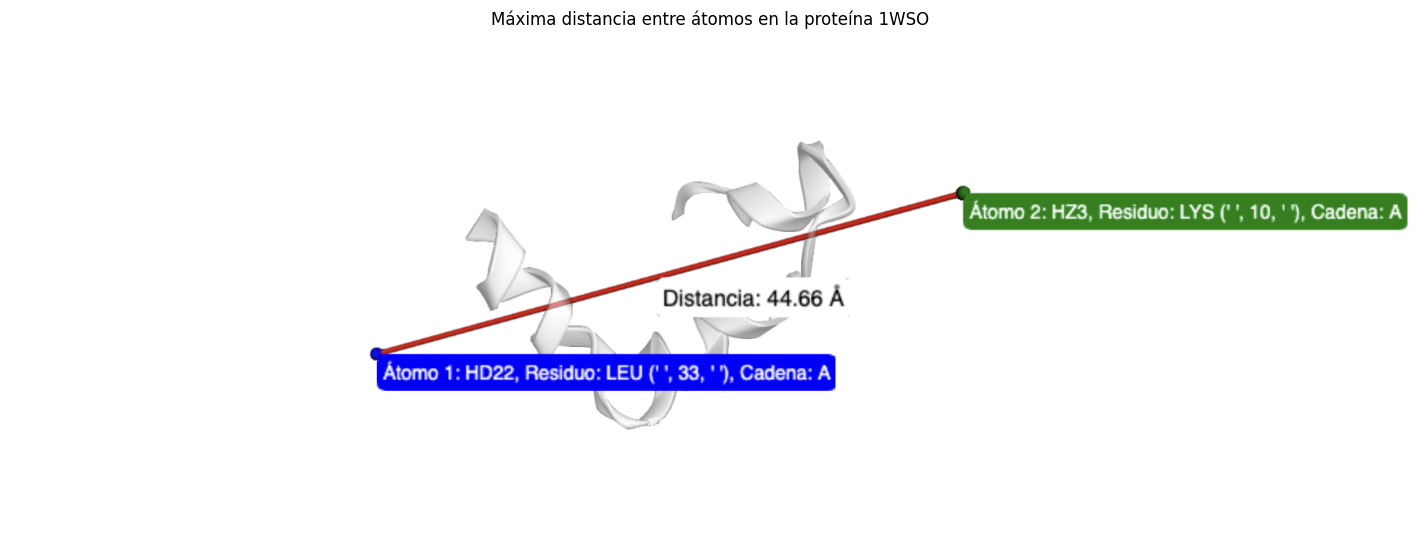

In [84]:
plt.figure(figsize=(14, 5))

img = mpimg.imread("results/dist_1wso.png")
plt.imshow(img)
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.title("Máxima distancia entre átomos en la proteína 1WSO")
plt.show()

Por ello, en este caso tiene sentido que la distancia sea tan grande, pues sabemos gracias a la fase de análisis exploratorio que esta proteína poseía dos ligandos ajenos a la estructura principal de la proteína. Veamos ahora que ocurre para la Orexina-B/Hipocretina-2.

In [86]:
pdb_file_path = "./data/1CQ0.pdb"
visualize_max_distance(pdb_file_path)

La distancia máxima entre átomos es: 34.73 Å
Átomo 1: HA2, Residuo: GLY (' ', 3, ' '), Cadena: A
Átomo 2: HG21, Residuo: THR (' ', 27, ' '), Cadena: A


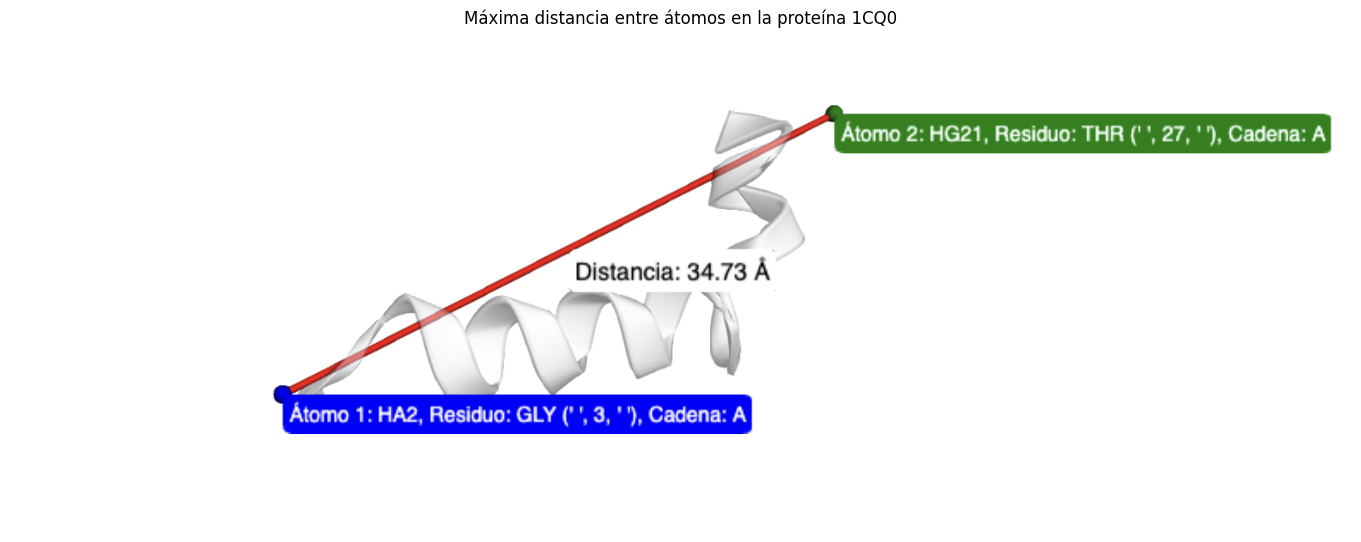

In [85]:
plt.figure(figsize=(14, 5))

img = mpimg.imread("results/dist_1cq0.png")
plt.imshow(img)
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.title("Máxima distancia entre átomos en la proteína 1CQ0")
plt.show()

Ahora bien, ¿por qué parecen haber ahora un nuevo ligando que antes no había? Si nos fijamos en el análisis exploratorio realizado al inicio de la práctica, no parecía haber ningún ligando separado de la cadena principal para la proteína 1CQ0. En efecto, tenemos:

In [75]:
def inspect_structure(structure):
    print("Residuos presentes en la estructura:")
    for model in structure:
        for chain in model:
            print(f"Cadena: {chain.id}")
            for residue in chain:
                print(f"Residuo: {residue.resname}, ID: {residue.id}, Atomos:")
                for atom in residue:
                    print(f"  Átomo: {atom.name}, Coordenadas: {atom.coord}")

def detect_residues_and_ligands(structure):
    residues = []
    ligands = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.id[0] == " ":
                    residues.append(residue)
                else:
                    ligands.append(residue)
    return residues, ligands

In [76]:
parser = PDB.MMCIFParser(QUIET=True)
structure_1cq0 = parser.get_structure("1WSO", "./data/1cq0.cif")

inspect_structure(structure_1cq0)

residues, ligands = detect_residues_and_ligands(structure_1cq0)

print("\nResiduos estándar detectados:")
for residue in residues:
    print(f"Residuo: {residue.resname}, ID: {residue.id}, Cadena: {residue.parent.id}")

print("\nLigandos detectados:")
if ligands:
    for ligand in ligands:
        print(f"Ligando: {ligand.resname}, ID: {ligand.id}, Cadena: {ligand.parent.id}")
else:
    print("No se detectaron ligandos.")

Residuos presentes en la estructura:
Cadena: A
Residuo: PHE, ID: (' ', 1, ' '), Atomos:
  Átomo: N, Coordenadas: [14.035  0.577  8.925]
  Átomo: CA, Coordenadas: [14.136 -0.728  9.641]
  Átomo: C, Coordenadas: [14.345 -1.866  8.638]
  Átomo: O, Coordenadas: [15.087 -2.795  8.886]
  Átomo: CB, Coordenadas: [12.798 -0.887 10.364]
  Átomo: CG, Coordenadas: [12.454  0.398 11.077]
  Átomo: CD1, Coordenadas: [13.436  1.077 11.808]
  Átomo: CD2, Coordenadas: [11.153  0.911 11.007]
  Átomo: CE1, Coordenadas: [13.117  2.269 12.47 ]
  Átomo: CE2, Coordenadas: [10.835  2.103 11.668]
  Átomo: CZ, Coordenadas: [11.816  2.782 12.4  ]
  Átomo: H1, Coordenadas: [14.375  1.34   9.544]
  Átomo: H2, Coordenadas: [13.043  0.754  8.667]
  Átomo: H3, Coordenadas: [14.618  0.547  8.065]
  Átomo: HA, Coordenadas: [14.942 -0.703 10.357]
  Átomo: HB2, Coordenadas: [12.026 -1.118  9.644]
  Átomo: HB3, Coordenadas: [12.871 -1.689 11.083]
  Átomo: HD1, Coordenadas: [14.439  0.681 11.862]
  Átomo: HD2, Coordenadas:

Ahora bien, ¿podría ser que, pese a que el residuo forme para de la cadena principal, este esté aislado? Para averiguarlo, calcularemos las distancias decada residuo a su residuo más cercano, y diremos que un residuo está aislado si supera u umbral de 1.5 Å.

In [80]:
def calculate_min_distance_to_closest_residue(residue, all_residues):
    atoms = [atom for res in all_residues if res != residue for atom in res.get_atoms()]
    
    residue_atoms = list(residue.get_atoms())
    
    min_distance = float("inf")
    
    for atom in residue_atoms:
        distances = [atom - other_atom for other_atom in atoms]
        if distances:
            min_distance = min(min_distance, min(distances))
    
    return min_distance


In [81]:
for residue in residues:
    min_distance = calculate_min_distance_to_closest_residue(residue, residues)
    print(f"Residuo: {residue.resname}, ID: {residue.id}, Cadena: {residue.parent.id}, Distancia mínima: {min_distance:.2f} Å")

Residuo: PHE, ID: (' ', 1, ' '), Cadena: A, Distancia mínima: 1.30 Å
Residuo: SER, ID: (' ', 2, ' '), Cadena: A, Distancia mínima: 1.30 Å
Residuo: GLY, ID: (' ', 3, ' '), Cadena: A, Distancia mínima: 1.30 Å
Residuo: PRO, ID: (' ', 4, ' '), Cadena: A, Distancia mínima: 1.30 Å
Residuo: PRO, ID: (' ', 5, ' '), Cadena: A, Distancia mínima: 1.29 Å
Residuo: GLY, ID: (' ', 6, ' '), Cadena: A, Distancia mínima: 1.29 Å
Residuo: LEU, ID: (' ', 7, ' '), Cadena: A, Distancia mínima: 1.30 Å
Residuo: GLN, ID: (' ', 8, ' '), Cadena: A, Distancia mínima: 1.30 Å
Residuo: GLY, ID: (' ', 9, ' '), Cadena: A, Distancia mínima: 1.30 Å
Residuo: ARG, ID: (' ', 10, ' '), Cadena: A, Distancia mínima: 1.30 Å
Residuo: LEU, ID: (' ', 11, ' '), Cadena: A, Distancia mínima: 1.29 Å
Residuo: GLN, ID: (' ', 12, ' '), Cadena: A, Distancia mínima: 1.29 Å
Residuo: ARG, ID: (' ', 13, ' '), Cadena: A, Distancia mínima: 1.29 Å
Residuo: LEU, ID: (' ', 14, ' '), Cadena: A, Distancia mínima: 1.29 Å
Residuo: LEU, ID: (' ', 15, '

En este caso, las distancias mínimas entre residuos no deberían mostrar residuos aislados ya que las distancias son muy pequeñas (del orden de 1.3 Å), lo que indica una proximidad esperada en una estructura compacta de proteína.

La razón por la cual los puntos se ven aislados podría deberse a la visualización del modelo:
- La visualización gráfica podría estar resaltando ciertos puntos (como átomos específicos) que parecen aislados, pero realmente no lo están.
- Es posible que las líneas que conectan los residuos no se dibujen para distancias más allá de un umbral, creando una falsa impresión de aislamiento.
- Error en la representación:
    - Si el software de visualización aplica filtros o condiciones adicionales para resaltar ciertos elementos, podría estar omitiendo conexiones válidas entre los residuos.


Concluimos, por tanto, que la proteína de la Orexina-A/Hipocretina-1 (1WSO) tiene una mayor distancia entre sus átomos que la Orexina-B/Hipocretina-2 (1CQ0), lo cual es consistente con las diferencias estructurales y funcionales observadas entre ambas proteínas. La presencia de ligandos adicionales en la Orexina-A podría contribuir a esta mayor distancia, lo que destaca la importancia de considerar la estructura completa de las proteínas al evaluar sus propiedades físicas y biológicas. Además, la comparación de las distancias entre átomos puede proporcionar información adicional sobre la estabilidad, la interacción con otras moléculas y la función de las proteínas, lo que es crucial para comprender su papel en los procesos biológicos y su relevancia en la salud y la enfermedad.

Esta mayor distancia también sugiere que la Orexina-A podría tener mayor flexibilidad estructural, lo que influiría en su capacidad para interactuar con diferentes receptores o adaptarse a diversos entornos moleculares. Esto podría explicar, en parte, su versatilidad funcional y su implicación en múltiples procesos fisiológicos. Por otro lado, las diferencias en compactación podrían tener implicaciones en la eficiencia del plegamiento y en la estabilidad de la proteína, aspectos clave en el diseño de fármacos que buscan modular la actividad de estas moléculas en el tratamiento de trastornos relacionados con el sistema orexinérgico.